In [1]:
# always start with checking out the files!
!ls ../input/*

../input/item_categories.csv	../input/sample_submission.csv.gz
../input/items.csv		../input/shops.csv
../input/sales_train.csv.gz	../input/test.csv
../input/sales_train_v2.csv	../input/test.csv.gz
../input/sample_submission.csv


In [2]:
import os
import math
import time
import shutil

# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

#from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
import scipy.stats as scs

import datetime as dt

from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt


# settings
import warnings
warnings.filterwarnings("ignore")



/home/bapanes/Simulation/anaconda3/envs/tensorflow/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/bapanes/Simulation/anaconda3/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/bapanes/Simulation/anaconda3/envs/tensorflow/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/bapanes/Simulation/anaconda3/envs/tensorflow/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/bapanes/S

In [3]:
# Import all of data inmediately  
sales=pd.read_csv("../input/sales_train_v2.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("../input/item_categories.csv")
item=pd.read_csv("../input/items.csv")
sub=pd.read_csv("../input/sample_submission.csv")
shops=pd.read_csv("../input/shops.csv")
test=pd.read_csv("../input/test.csv")

In [4]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


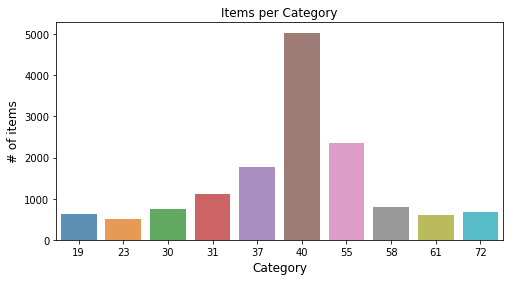

In [5]:
# number of items per cat 
#notice that the analisis tupla is simply x

x=item.groupby(['item_category_id']).count()

x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

# Single series:

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.


In [6]:
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

# Definition of ts = date_block,  item_cnt_day.sum dataframe
Now, we declare a new variable to define the data to analyze in terms of time series predictions
basically, the item_cnt_day added in differents directions, such as date_block_num or date_block_num x shop_id x item_id, etc.

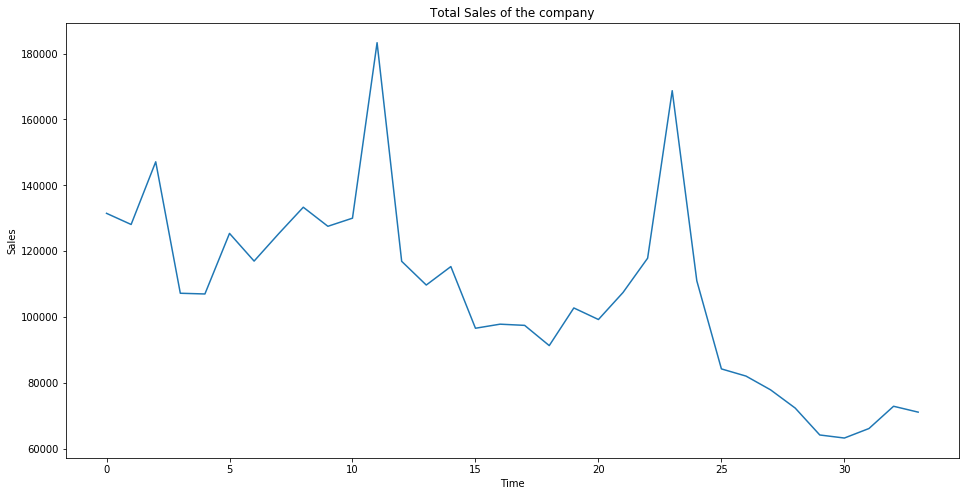

In [7]:
#declaration of time-series kind of variable ts with groupby, but the structure is simple

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()


ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

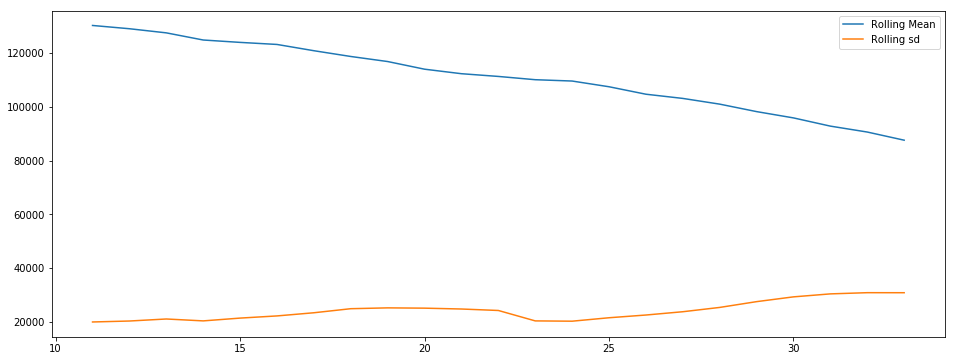

In [8]:
#with ts.rolling we are computing the mean and std of sales grouped in windows of size 12 in units of time (block times, indeed)

plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

# Starting the LSTM model 

We consider the predictio  of each node independently by using as basis source of information to run the LSTM algorithm the monthly evolution of the count of sales for each node 

In [8]:
#checking the requirements of the test file

test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [15]:
#Function that generate a dataframe with featured columns (total_cnt for instance)
    
def sales_summary_dataframe(shop_id_history, item_id_history):
   
    sales_shop_item = sales[(sales.shop_id==shop_id_history) & (sales.item_id == item_id_history)]
    monthly_sales_shop_item = sales_shop_item.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    
    nullhistory = pd.DataFrame({"node_tot_cnt":[0]*dates.shape[0]},columns=["node_tot_cnt"])
    
    if (sales_shop_item.shape[0] > 0):
        for con in range(monthly_sales_shop_item.shape[0]): 
            index_date_block = monthly_sales_shop_item.index[con]
            count_date_block = monthly_sales_shop_item.iloc[con]
   
            # here we fill the histories, always leaving the zero position to the featiure 
            # to be predicted [0]!!!!
            nullhistory.iloc[index_date_block,0] = count_date_block
    
    return nullhistory    

In [9]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [10]:
class Timer():

    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))

In [11]:
class Model():
    """A class for an building and inferencing an lstm model"""

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]
        
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks)
        self.model.save(save_fname)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
        
        save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
        callbacks = [
            ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]
        self.model.fit_generator(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            workers=1
        )

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def predict_point_by_point(self, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len):
        #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
        print('[Model] Predicting Sequences Multiple...')
        prediction_seqs = []
        for i in range(int(len(data)/prediction_len)):
            curr_frame = data[i*prediction_len]
            predicted = []
            for j in range(prediction_len):
                predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        #Shift the window by 1 new prediction each time, re-run predictions on new window
        print('[Model] Predicting Sequences Full...')
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        return predicted

In [12]:
class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, dataframe, split, cols):
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                
                
                #normalised_col = [((float(p) / window[0,col_i]) - 1) for p in window[:, col_i]]
                
                #new normalization necessary since there are several times when window[0,col_i]=0
                #but still we like the idea to normalize each window wrt to the initial value
                
                normalised_col = [(float(p) - window[0,col_i]) for p in window[:, col_i]]
                
                normalised_window.append(normalised_col)
                
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [17]:
#we are going to use all the input file as train train_test_split": 1.0
#since we just need to predict the next month sales

#input_timesteps MUST BE EQUAL to sequence_length - 1
#in order to avoid array size compatibility problems

sequence_length = 6
input_timesteps = sequence_length - 1

configs = {"data": {"filename": "sales_train.csv", "columns": ["node_tot_cnt"],
                    "sequence_length": sequence_length, "train_test_split": 1.0, "normalise": True},
           "training": {"epochs": 2, "batch_size": 8},
           "model": {"loss": "mse", "optimizer": "adam", "save_dir": "saved_models",
                     "layers": [{"type": "lstm", "neurons": 100, "input_timesteps": input_timesteps, 
                                 "input_dim": 1, "return_seq": True},
                                {"type": "dropout", "rate": 0.2},
                                {"type": "lstm", "neurons": 100, "return_seq": True},
                                {"type": "lstm", "neurons": 100, "return_seq": False},
                                {"type": "dropout", "rate": 0.2},
                                {"type": "dense", "neurons": 1, "activation": "linear"}]}}

In [ ]:
start_time=time.time()

if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

model = Model()
model.build_model(configs)
 
list_of_nodes =[]
list_of_predictions = []

status_file = open('status_file_LSTM.txt','w+')
status_file.write("Dont be patient\n")
status_file.close()

for node in range(len(test)):
#for node in range(40):    
    
    
    #restarting the save_dir file because we are assuming that each node is an
    #independent set of data
    
    shutil.rmtree(configs['model']['save_dir'], ignore_errors=True)
    os.makedirs(configs['model']['save_dir'])
    
    # reading the node address
    # here we should start the loop

    test_shop_id_index = test.iloc[node,1]
    test_item_id_index = test.iloc[node,2]

    #creating the summary data frame
    
    sales_summary_df = sales_summary_dataframe(test_shop_id_index, test_item_id_index)
   
    #using summary data frame to define the LSTM input as in Stock Market Predictor

    data = DataLoader(sales_summary_df,
                  configs['data']['train_test_split'],
                  configs['data']['columns'])

    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    
    model.train_generator(
                data_gen=data.generate_train_batch(
                seq_len=configs['data']['sequence_length'],
                batch_size=configs['training']['batch_size'],
                normalise=configs['data']['normalise']
                ),
                epochs=configs['training']['epochs'],
                batch_size=configs['training']['batch_size'],
                steps_per_epoch=steps_per_epoch,
                save_dir=configs['model']['save_dir']
        )

     #making prediction based in the last block of months (for now we are using 5 months)
     #this is clearly more consistent when we use normalize = False in configs variable
     #when we use normalize = True we should be carefull about final predictions, because
     #they could be afected by the normalization of the training data 
        
    ini_element = sales_summary_df.values.shape[0]-configs['data']['sequence_length'] + 1
    end_element = sales_summary_df.values.shape[0]
    last_train_block = np.array([sales_summary_df.values[ini_element:end_element]])

    #prediction for next month based on precious sequence_length months (last train block!!)
    memory_based_prediction_for_next_month = model.predict_point_by_point(last_train_block)
    
    list_of_nodes.append(node)
    list_of_predictions.append(memory_based_prediction_for_next_month[0])
    
    if (((node % 10 == 0) and (node < 100)) or (node % 1000 == 0)):
        end_time=time.time()
        
        #status_output = "forecasting for "+ str(node) +"th node and took" + str(end_time-start_time) + "s"

        status_file = open('status_file_LSTM.txt','a')
        
        status_file.write("Node "+ str(node) +" took " + str(end_time-start_time) + " s with ") 
        status_file.write("Prediction: "+ str(memory_based_prediction_for_next_month[0]) + "\n")

        status_file.close()

        #print()
        start_time=end_time

#total submission file        
        
    
    
dfsubmission = pd.DataFrame({"ID":list_of_nodes,"item_cnt_month":list_of_predictions},
                            columns=["ID","item_cnt_month"])

dfsubmission.to_csv('submission_file_LSTM_normalized_True.csv',index=False)

[Model] Model Compiled
Time taken: 0:00:00.623156
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 2s 606ms/step - loss: 0.5362
Epoch 2/2
3/3 [==============================] - 0s 15ms/step - loss: 1.3775
[Model] Training Completed. Model saved as saved_models/17112018-204812-e2.h5
Time taken: 0:00:04.547038
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0034
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0056
[Model] Training Completed. Model saved as saved_models/17112018-204817-e2.h5
Time taken: 0:00:00.175772
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 26ms/step - loss: 0.3646
Epoch 2/2
3/3 [============================

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 8.7322
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.2209
[Model] Training Completed. Model saved as saved_models/17112018-204822-e2.h5
Time taken: 0:00:00.224697
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7162
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3965
[Model] Training Completed. Model saved as saved_models/17112018-204822-e2.h5
Time taken: 0:00:00.216649
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 31ms/step - loss: 0.5808
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.6231
[Model] Training 

3/3 [==============================] - 0s 25ms/step - loss: 0.0329
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.3620
[Model] Training Completed. Model saved as saved_models/17112018-204827-e2.h5
Time taken: 0:00:00.206058
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0917
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0769
[Model] Training Completed. Model saved as saved_models/17112018-204828-e2.h5
Time taken: 0:00:00.228936
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 14.3293
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 6.8495
[Model] Training Completed. Model saved as saved_models/17112018-204828-e2.h5
Time taken: 0:00:00.225472


3/3 [==============================] - 0s 20ms/step - loss: 1.0145
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 1.8935
[Model] Training Completed. Model saved as saved_models/17112018-204833-e2.h5
Time taken: 0:00:00.162724
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1394
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0520
[Model] Training Completed. Model saved as saved_models/17112018-204833-e2.h5
Time taken: 0:00:00.216970
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 26ms/step - loss: 0.0440
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3490
[Model] Training Completed. Model saved as saved_models/17112018-204833-e2.h5
Time taken: 0:00:00.182189
[

3/3 [==============================] - 0s 22ms/step - loss: 42.9477
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 43.7133
[Model] Training Completed. Model saved as saved_models/17112018-204838-e2.h5
Time taken: 0:00:00.181415
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 21.9481
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 17.9721
[Model] Training Completed. Model saved as saved_models/17112018-204838-e2.h5
Time taken: 0:00:00.221398
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.2327
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.1734
[Model] Training Completed. Model saved as saved_models/17112018-204838-e2.h5
Time taken: 0:00:00.1880

3/3 [==============================] - 0s 20ms/step - loss: 0.1981
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.8567
[Model] Training Completed. Model saved as saved_models/17112018-204843-e2.h5
Time taken: 0:00:00.168005
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1115
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1052
[Model] Training Completed. Model saved as saved_models/17112018-204843-e2.h5
Time taken: 0:00:00.212190
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0770
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0614
[Model] Training Completed. Model saved as saved_models/17112018-204843-e2.h5
Time taken: 0:00:00.212526
[

3/3 [==============================] - 0s 22ms/step - loss: 9.8735e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.1313e-04
[Model] Training Completed. Model saved as saved_models/17112018-204848-e2.h5
Time taken: 0:00:00.241992
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-204848-e2.h5
Time taken: 0:00:00.196488
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.2307
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0327
[Model] Training Completed. Model saved as saved_models/17112018-204848-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 22ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-204853-e2.h5
Time taken: 0:00:00.217906
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.0085
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6487
[Model] Training Completed. Model saved as saved_models/17112018-204853-e2.h5
Time taken: 0:00:00.218213
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2642
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4331
[Model] Training Completed. Model saved as saved_models/17112018-204853-e2.h5
Time taken: 0:00:00.179373
[

3/3 [==============================] - 0s 19ms/step - loss: 0.3037
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 1.0251
[Model] Training Completed. Model saved as saved_models/17112018-204858-e2.h5
Time taken: 0:00:00.172358
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2411
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2481
[Model] Training Completed. Model saved as saved_models/17112018-204858-e2.h5
Time taken: 0:00:00.175989
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.6953
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6216
[Model] Training Completed. Model saved as saved_models/17112018-204858-e2.h5
Time taken: 0:00:00.207751
[

3/3 [==============================] - 0s 19ms/step - loss: 2.0588
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.1759
[Model] Training Completed. Model saved as saved_models/17112018-204903-e2.h5
Time taken: 0:00:00.208388
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0111
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0081
[Model] Training Completed. Model saved as saved_models/17112018-204903-e2.h5
Time taken: 0:00:00.211231
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0055
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0044
[Model] Training Completed. Model saved as saved_models/17112018-204903-e2.h5
Time taken: 0:00:00.202741
[

3/3 [==============================] - 0s 21ms/step - loss: 0.2992
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.1741
[Model] Training Completed. Model saved as saved_models/17112018-204908-e2.h5
Time taken: 0:00:00.169489
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0058
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0058
[Model] Training Completed. Model saved as saved_models/17112018-204908-e2.h5
Time taken: 0:00:00.166706
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0071
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0070
[Model] Training Completed. Model saved as saved_models/17112018-204908-e2.h5
Time taken: 0:00:00.179390
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0098
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0114
[Model] Training Completed. Model saved as saved_models/17112018-204912-e2.h5
Time taken: 0:00:00.172675
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0084
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-204913-e2.h5
Time taken: 0:00:00.211251
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0058
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0044
[Model] Training Completed. Model saved as saved_models/17112018-204913-e2.h5
Time taken: 0:00:00.205902
[

3/3 [==============================] - 0s 21ms/step - loss: 0.1776
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0437
[Model] Training Completed. Model saved as saved_models/17112018-204917-e2.h5
Time taken: 0:00:00.224733
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4723
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3003
[Model] Training Completed. Model saved as saved_models/17112018-204917-e2.h5
Time taken: 0:00:00.203134
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-204918-e2.h5
Time taken: 0:00:00.173015
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0038
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0026
[Model] Training Completed. Model saved as saved_models/17112018-204922-e2.h5
Time taken: 0:00:00.216571
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.6344
[Model] Training Completed. Model saved as saved_models/17112018-204922-e2.h5
Time taken: 0:00:00.171378
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1476
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3068
[Model] Training Completed. Model saved as saved_models/17112018-204922-e2.h5
Time taken: 0:00:00.163652
[

3/3 [==============================] - 0s 21ms/step - loss: 0.3945
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.3695
[Model] Training Completed. Model saved as saved_models/17112018-204927-e2.h5
Time taken: 0:00:00.201644
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0033
[Model] Training Completed. Model saved as saved_models/17112018-204927-e2.h5
Time taken: 0:00:00.162489
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-204927-e2.h5
Time taken: 0:00:00.228942
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0028
[Model] Training Completed. Model saved as saved_models/17112018-204931-e2.h5
Time taken: 0:00:00.180993
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0045
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0026
[Model] Training Completed. Model saved as saved_models/17112018-204932-e2.h5
Time taken: 0:00:00.197892
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0604
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1545
[Model] Training Completed. Model saved as saved_models/17112018-204932-e2.h5
Time taken: 0:00:00.166868
[

3/3 [==============================] - 0s 25ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0049
[Model] Training Completed. Model saved as saved_models/17112018-204936-e2.h5
Time taken: 0:00:00.185440
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.5843
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1776
[Model] Training Completed. Model saved as saved_models/17112018-204936-e2.h5
Time taken: 0:00:00.212313
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0039
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0027
[Model] Training Completed. Model saved as saved_models/17112018-204936-e2.h5
Time taken: 0:00:00.211511
[

3/3 [==============================] - 0s 24ms/step - loss: 0.3902
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.3790
[Model] Training Completed. Model saved as saved_models/17112018-204941-e2.h5
Time taken: 0:00:00.186406
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3576
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 5.9769
[Model] Training Completed. Model saved as saved_models/17112018-204941-e2.h5
Time taken: 0:00:00.170362
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3899
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.3539
[Model] Training Completed. Model saved as saved_models/17112018-204941-e2.h5
Time taken: 0:00:00.169967
[

3/3 [==============================] - 0s 27ms/step - loss: 5.7749
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 4.7426
[Model] Training Completed. Model saved as saved_models/17112018-204946-e2.h5
Time taken: 0:00:00.217452
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 22.8280
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 22.8710
[Model] Training Completed. Model saved as saved_models/17112018-204946-e2.h5
Time taken: 0:00:00.170497
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0617
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1237
[Model] Training Completed. Model saved as saved_models/17112018-204946-e2.h5
Time taken: 0:00:00.183268

3/3 [==============================] - 0s 21ms/step - loss: 0.0055
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0059
[Model] Training Completed. Model saved as saved_models/17112018-204950-e2.h5
Time taken: 0:00:00.172427
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0033
[Model] Training Completed. Model saved as saved_models/17112018-204951-e2.h5
Time taken: 0:00:00.170429
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 1.2284
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.9924
[Model] Training Completed. Model saved as saved_models/17112018-204951-e2.h5
Time taken: 0:00:00.213579
[

3/3 [==============================] - 0s 20ms/step - loss: 0.4479
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1290
[Model] Training Completed. Model saved as saved_models/17112018-204955-e2.h5
Time taken: 0:00:00.208402
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 8.7650
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2354
[Model] Training Completed. Model saved as saved_models/17112018-204955-e2.h5
Time taken: 0:00:00.198301
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1213
[Model] Training Completed. Model saved as saved_models/17112018-204956-e2.h5
Time taken: 0:00:00.162969
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0194
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-205000-e2.h5
Time taken: 0:00:00.215956
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 1.7881
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8462
[Model] Training Completed. Model saved as saved_models/17112018-205000-e2.h5
Time taken: 0:00:00.162892
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 14.7888
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 8.2449
[Model] Training Completed. Model saved as saved_models/17112018-205000-e2.h5
Time taken: 0:00:00.229086


3/3 [==============================] - 0s 20ms/step - loss: 1.3587
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.6031
[Model] Training Completed. Model saved as saved_models/17112018-205005-e2.h5
Time taken: 0:00:00.206055
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.8890
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.7477
[Model] Training Completed. Model saved as saved_models/17112018-205005-e2.h5
Time taken: 0:00:00.201019
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 3.0393
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.2851
[Model] Training Completed. Model saved as saved_models/17112018-205005-e2.h5
Time taken: 0:00:00.161175
[

3/3 [==============================] - 0s 22ms/step - loss: 2.3765
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.5107
[Model] Training Completed. Model saved as saved_models/17112018-205009-e2.h5
Time taken: 0:00:00.207789
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5534
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.6971
[Model] Training Completed. Model saved as saved_models/17112018-205010-e2.h5
Time taken: 0:00:00.170286
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0964
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.8911
[Model] Training Completed. Model saved as saved_models/17112018-205010-e2.h5
Time taken: 0:00:00.178099
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1175
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0477
[Model] Training Completed. Model saved as saved_models/17112018-205014-e2.h5
Time taken: 0:00:00.210435
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3760
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2598
[Model] Training Completed. Model saved as saved_models/17112018-205015-e2.h5
Time taken: 0:00:00.206746
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0090
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0075
[Model] Training Completed. Model saved as saved_models/17112018-205015-e2.h5
Time taken: 0:00:00.201057
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0088
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0057
[Model] Training Completed. Model saved as saved_models/17112018-205019-e2.h5
Time taken: 0:00:00.216518
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5993
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.6557
[Model] Training Completed. Model saved as saved_models/17112018-205019-e2.h5
Time taken: 0:00:00.207530
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.5009
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.6387
[Model] Training Completed. Model saved as saved_models/17112018-205020-e2.h5
Time taken: 0:00:00.210314
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0113
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1209
[Model] Training Completed. Model saved as saved_models/17112018-205024-e2.h5
Time taken: 0:00:00.165610
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2395
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2837
[Model] Training Completed. Model saved as saved_models/17112018-205024-e2.h5
Time taken: 0:00:00.168364
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0295
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0255
[Model] Training Completed. Model saved as saved_models/17112018-205024-e2.h5
Time taken: 0:00:00.220941
[

3/3 [==============================] - 0s 25ms/step - loss: 0.4726
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4715
[Model] Training Completed. Model saved as saved_models/17112018-205029-e2.h5
Time taken: 0:00:00.215724
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 1.5068
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.2241
[Model] Training Completed. Model saved as saved_models/17112018-205029-e2.h5
Time taken: 0:00:00.204867
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0919
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1731
[Model] Training Completed. Model saved as saved_models/17112018-205029-e2.h5
Time taken: 0:00:00.165385
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0194
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0358
[Model] Training Completed. Model saved as saved_models/17112018-205034-e2.h5
Time taken: 0:00:00.181307
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.6903
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1552
[Model] Training Completed. Model saved as saved_models/17112018-205034-e2.h5
Time taken: 0:00:00.221103
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0394
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0846
[Model] Training Completed. Model saved as saved_models/17112018-205034-e2.h5
Time taken: 0:00:00.157755
[

3/3 [==============================] - 0s 18ms/step - loss: 2.3652
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4913
[Model] Training Completed. Model saved as saved_models/17112018-205038-e2.h5
Time taken: 0:00:00.199904
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5199
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1098
[Model] Training Completed. Model saved as saved_models/17112018-205039-e2.h5
Time taken: 0:00:00.199984
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 5.2336
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.7497
[Model] Training Completed. Model saved as saved_models/17112018-205039-e2.h5
Time taken: 0:00:00.207973
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0073
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.4626
[Model] Training Completed. Model saved as saved_models/17112018-205043-e2.h5
Time taken: 0:00:00.169323
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1733
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2841
[Model] Training Completed. Model saved as saved_models/17112018-205043-e2.h5
Time taken: 0:00:00.173834
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0172
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0152
[Model] Training Completed. Model saved as saved_models/17112018-205043-e2.h5
Time taken: 0:00:00.206648
[

3/3 [==============================] - 0s 21ms/step - loss: 44.2690
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.6600
[Model] Training Completed. Model saved as saved_models/17112018-205048-e2.h5
Time taken: 0:00:00.207530
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0942
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0658
[Model] Training Completed. Model saved as saved_models/17112018-205048-e2.h5
Time taken: 0:00:00.200024
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0302
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0118
[Model] Training Completed. Model saved as saved_models/17112018-205048-e2.h5
Time taken: 0:00:00.199698


3/3 [==============================] - 0s 19ms/step - loss: 0.0473
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0606
[Model] Training Completed. Model saved as saved_models/17112018-205052-e2.h5
Time taken: 0:00:00.160042
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0318
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0197
[Model] Training Completed. Model saved as saved_models/17112018-205053-e2.h5
Time taken: 0:00:00.233175
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1703
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.3070
[Model] Training Completed. Model saved as saved_models/17112018-205053-e2.h5
Time taken: 0:00:00.188094
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0236
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.9409
[Model] Training Completed. Model saved as saved_models/17112018-205057-e2.h5
Time taken: 0:00:00.174262
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0221
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0289
[Model] Training Completed. Model saved as saved_models/17112018-205057-e2.h5
Time taken: 0:00:00.176614
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0204
Epoch 2/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0156
[Model] Training Completed. Model saved as saved_models/17112018-205058-e2.h5
Time taken: 0:00:00.222268
[

3/3 [==============================] - 0s 22ms/step - loss: 0.7244
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 1.3326
[Model] Training Completed. Model saved as saved_models/17112018-205102-e2.h5
Time taken: 0:00:00.176625
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0925
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0626
[Model] Training Completed. Model saved as saved_models/17112018-205102-e2.h5
Time taken: 0:00:00.221869
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.3731
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0919
[Model] Training Completed. Model saved as saved_models/17112018-205102-e2.h5
Time taken: 0:00:00.225304
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0088
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0136
[Model] Training Completed. Model saved as saved_models/17112018-205107-e2.h5
Time taken: 0:00:00.171207
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0087
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0097
[Model] Training Completed. Model saved as saved_models/17112018-205107-e2.h5
Time taken: 0:00:00.169009
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1474
[Model] Training Completed. Model saved as saved_models/17112018-205107-e2.h5
Time taken: 0:00:00.177756
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0065
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-205111-e2.h5
Time taken: 0:00:00.219279
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0056
[Model] Training Completed. Model saved as saved_models/17112018-205111-e2.h5
Time taken: 0:00:00.155935
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0049
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0061
[Model] Training Completed. Model saved as saved_models/17112018-205112-e2.h5
Time taken: 0:00:00.172541
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0830
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0409
[Model] Training Completed. Model saved as saved_models/17112018-205116-e2.h5
Time taken: 0:00:00.209199
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4939
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1726
[Model] Training Completed. Model saved as saved_models/17112018-205116-e2.h5
Time taken: 0:00:00.202378
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 8.1342
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.5025
[Model] Training Completed. Model saved as saved_models/17112018-205116-e2.h5
Time taken: 0:00:00.163919
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0104
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0053
[Model] Training Completed. Model saved as saved_models/17112018-205121-e2.h5
Time taken: 0:00:00.210021
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0054
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.4445
[Model] Training Completed. Model saved as saved_models/17112018-205121-e2.h5
Time taken: 0:00:00.162575
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0093
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.0763
[Model] Training Completed. Model saved as saved_models/17112018-205121-e2.h5
Time taken: 0:00:00.166962
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0259
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0137
[Model] Training Completed. Model saved as saved_models/17112018-205125-e2.h5
Time taken: 0:00:00.214280
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0066
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2217
[Model] Training Completed. Model saved as saved_models/17112018-205126-e2.h5
Time taken: 0:00:00.160932
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3304
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3658
[Model] Training Completed. Model saved as saved_models/17112018-205126-e2.h5
Time taken: 0:00:00.170762
[

3/3 [==============================] - 0s 21ms/step - loss: 0.3269
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1550
[Model] Training Completed. Model saved as saved_models/17112018-205130-e2.h5
Time taken: 0:00:00.229623
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0040
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-205130-e2.h5
Time taken: 0:00:00.206309
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.0753
[Model] Training Completed. Model saved as saved_models/17112018-205131-e2.h5
Time taken: 0:00:00.173061
[

3/3 [==============================] - 0s 24ms/step - loss: 0.0258
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1461
[Model] Training Completed. Model saved as saved_models/17112018-205135-e2.h5
Time taken: 0:00:00.181696
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0345
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0192
[Model] Training Completed. Model saved as saved_models/17112018-205135-e2.h5
Time taken: 0:00:00.200956
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0098
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.0067
[Model] Training Completed. Model saved as saved_models/17112018-205135-e2.h5
Time taken: 0:00:00.163975
[

3/3 [==============================] - 0s 19ms/step - loss: 0.2534
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4274
[Model] Training Completed. Model saved as saved_models/17112018-205140-e2.h5
Time taken: 0:00:00.158906
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.1006
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2551
[Model] Training Completed. Model saved as saved_models/17112018-205140-e2.h5
Time taken: 0:00:00.181215
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0663
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.5292
[Model] Training Completed. Model saved as saved_models/17112018-205140-e2.h5
Time taken: 0:00:00.178245
[

3/3 [==============================] - 0s 19ms/step - loss: 0.1205
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1098
[Model] Training Completed. Model saved as saved_models/17112018-205144-e2.h5
Time taken: 0:00:00.205627
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1769
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1148
[Model] Training Completed. Model saved as saved_models/17112018-205144-e2.h5
Time taken: 0:00:00.198047
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0043
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0045
[Model] Training Completed. Model saved as saved_models/17112018-205145-e2.h5
Time taken: 0:00:00.200383
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1597
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1471
[Model] Training Completed. Model saved as saved_models/17112018-205149-e2.h5
Time taken: 0:00:00.162260
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4752
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2213
[Model] Training Completed. Model saved as saved_models/17112018-205149-e2.h5
Time taken: 0:00:00.221498
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0056
[Model] Training Completed. Model saved as saved_models/17112018-205149-e2.h5
Time taken: 0:00:00.165147
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0046
[Model] Training Completed. Model saved as saved_models/17112018-205154-e2.h5
Time taken: 0:00:00.180540
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1206
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4142
[Model] Training Completed. Model saved as saved_models/17112018-205154-e2.h5
Time taken: 0:00:00.161400
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0807
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3216
[Model] Training Completed. Model saved as saved_models/17112018-205154-e2.h5
Time taken: 0:00:00.191082
[

3/3 [==============================] - 0s 20ms/step - loss: 5.0215
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 4.8101
[Model] Training Completed. Model saved as saved_models/17112018-205159-e2.h5
Time taken: 0:00:00.166869
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 74.4933
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 57.4722
[Model] Training Completed. Model saved as saved_models/17112018-205159-e2.h5
Time taken: 0:00:00.213940
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.9201
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.3451
[Model] Training Completed. Model saved as saved_models/17112018-205159-e2.h5
Time taken: 0:00:00.165648

3/3 [==============================] - 0s 21ms/step - loss: 0.2182
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4412
[Model] Training Completed. Model saved as saved_models/17112018-205203-e2.h5
Time taken: 0:00:00.172351
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.9235
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.7730
[Model] Training Completed. Model saved as saved_models/17112018-205204-e2.h5
Time taken: 0:00:00.219296
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.7069
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5968
[Model] Training Completed. Model saved as saved_models/17112018-205204-e2.h5
Time taken: 0:00:00.206727
[

3/3 [==============================] - 0s 19ms/step - loss: 0.2368
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2767
[Model] Training Completed. Model saved as saved_models/17112018-205208-e2.h5
Time taken: 0:00:00.164797
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0056
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0069
[Model] Training Completed. Model saved as saved_models/17112018-205208-e2.h5
Time taken: 0:00:00.166009
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0064
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-205208-e2.h5
Time taken: 0:00:00.217932
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0044
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0027
[Model] Training Completed. Model saved as saved_models/17112018-205213-e2.h5
Time taken: 0:00:00.208767
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1977
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1723
[Model] Training Completed. Model saved as saved_models/17112018-205213-e2.h5
Time taken: 0:00:00.210076
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2604
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0495
[Model] Training Completed. Model saved as saved_models/17112018-205213-e2.h5
Time taken: 0:00:00.210475
[

3/3 [==============================] - 0s 19ms/step - loss: 0.6721
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2211
[Model] Training Completed. Model saved as saved_models/17112018-205218-e2.h5
Time taken: 0:00:00.197387
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0122
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0969
[Model] Training Completed. Model saved as saved_models/17112018-205218-e2.h5
Time taken: 0:00:00.168403
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0274
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1689
[Model] Training Completed. Model saved as saved_models/17112018-205218-e2.h5
Time taken: 0:00:00.165106
[

3/3 [==============================] - 0s 23ms/step - loss: 0.3308
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0606
[Model] Training Completed. Model saved as saved_models/17112018-205222-e2.h5
Time taken: 0:00:00.221943
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0055
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0036
[Model] Training Completed. Model saved as saved_models/17112018-205223-e2.h5
Time taken: 0:00:00.199349
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0478
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0144
[Model] Training Completed. Model saved as saved_models/17112018-205223-e2.h5
Time taken: 0:00:00.210707
[

3/3 [==============================] - 0s 23ms/step - loss: 0.4845
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1291
[Model] Training Completed. Model saved as saved_models/17112018-205227-e2.h5
Time taken: 0:00:00.217144
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0043
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.2445
[Model] Training Completed. Model saved as saved_models/17112018-205227-e2.h5
Time taken: 0:00:00.167632
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 6.0442
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.2443
[Model] Training Completed. Model saved as saved_models/17112018-205228-e2.h5
Time taken: 0:00:00.214902
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0045
[Model] Training Completed. Model saved as saved_models/17112018-205232-e2.h5
Time taken: 0:00:00.176333
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-205232-e2.h5
Time taken: 0:00:00.164756
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0026
[Model] Training Completed. Model saved as saved_models/17112018-205232-e2.h5
Time taken: 0:00:00.216034
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0787
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0252
[Model] Training Completed. Model saved as saved_models/17112018-205237-e2.h5
Time taken: 0:00:00.215819
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0033
[Model] Training Completed. Model saved as saved_models/17112018-205237-e2.h5
Time taken: 0:00:00.172937
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0523
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1203
[Model] Training Completed. Model saved as saved_models/17112018-205237-e2.h5
Time taken: 0:00:00.181594
[

3/3 [==============================] - 0s 23ms/step - loss: 0.2931
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1807
[Model] Training Completed. Model saved as saved_models/17112018-205241-e2.h5
Time taken: 0:00:00.222645
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1806
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2288
[Model] Training Completed. Model saved as saved_models/17112018-205242-e2.h5
Time taken: 0:00:00.162562
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.1885
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 2.8566
[Model] Training Completed. Model saved as saved_models/17112018-205242-e2.h5
Time taken: 0:00:00.181512
[

3/3 [==============================] - 0s 23ms/step - loss: 0.2082
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5481
[Model] Training Completed. Model saved as saved_models/17112018-205246-e2.h5
Time taken: 0:00:00.171525
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.3740
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3489
[Model] Training Completed. Model saved as saved_models/17112018-205246-e2.h5
Time taken: 0:00:00.217536
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0628
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0547
[Model] Training Completed. Model saved as saved_models/17112018-205247-e2.h5
Time taken: 0:00:00.213748
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0077
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1211
[Model] Training Completed. Model saved as saved_models/17112018-205251-e2.h5
Time taken: 0:00:00.172015
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 61.3943
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 47.0679
[Model] Training Completed. Model saved as saved_models/17112018-205251-e2.h5
Time taken: 0:00:00.208194
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 11.1661
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 1.2424
[Model] Training Completed. Model saved as saved_models/17112018-205251-e2.h5
Time taken: 0:00:00.20869

3/3 [==============================] - 0s 20ms/step - loss: 1.5617
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.2057
[Model] Training Completed. Model saved as saved_models/17112018-205256-e2.h5
Time taken: 0:00:00.211799
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0145
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0121
[Model] Training Completed. Model saved as saved_models/17112018-205256-e2.h5
Time taken: 0:00:00.202222
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0066
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0044
[Model] Training Completed. Model saved as saved_models/17112018-205256-e2.h5
Time taken: 0:00:00.196422
[

3/3 [==============================] - 0s 23ms/step - loss: 0.2079
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.1581
[Model] Training Completed. Model saved as saved_models/17112018-205301-e2.h5
Time taken: 0:00:00.178328
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3295
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3221
[Model] Training Completed. Model saved as saved_models/17112018-205301-e2.h5
Time taken: 0:00:00.212092
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.3280
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2874
[Model] Training Completed. Model saved as saved_models/17112018-205301-e2.h5
Time taken: 0:00:00.213861
[

3/3 [==============================] - 0s 24ms/step - loss: 0.0049
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1093
[Model] Training Completed. Model saved as saved_models/17112018-205305-e2.h5
Time taken: 0:00:00.188422
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0027
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1442
[Model] Training Completed. Model saved as saved_models/17112018-205306-e2.h5
Time taken: 0:00:00.173470
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0044
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0038
[Model] Training Completed. Model saved as saved_models/17112018-205306-e2.h5
Time taken: 0:00:00.219043
[

3/3 [==============================] - 0s 20ms/step - loss: 2.8841
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2180
[Model] Training Completed. Model saved as saved_models/17112018-205310-e2.h5
Time taken: 0:00:00.200765
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0540
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0043
[Model] Training Completed. Model saved as saved_models/17112018-205310-e2.h5
Time taken: 0:00:00.199295
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-205311-e2.h5
Time taken: 0:00:00.202272
[

3/3 [==============================] - 0s 21ms/step - loss: 0.4286
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1476
[Model] Training Completed. Model saved as saved_models/17112018-205315-e2.h5
Time taken: 0:00:00.202926
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.5989
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2936
[Model] Training Completed. Model saved as saved_models/17112018-205315-e2.h5
Time taken: 0:00:00.206914
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2171
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1433
[Model] Training Completed. Model saved as saved_models/17112018-205315-e2.h5
Time taken: 0:00:00.194159
[

3/3 [==============================] - 0s 21ms/step - loss: 0.3331
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5863
[Model] Training Completed. Model saved as saved_models/17112018-205320-e2.h5
Time taken: 0:00:00.173417
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.2261
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2692
[Model] Training Completed. Model saved as saved_models/17112018-205320-e2.h5
Time taken: 0:00:00.182433
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2384
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0895
[Model] Training Completed. Model saved as saved_models/17112018-205320-e2.h5
Time taken: 0:00:00.209258
[

3/3 [==============================] - 0s 22ms/step - loss: 0.2095
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1190
[Model] Training Completed. Model saved as saved_models/17112018-205324-e2.h5
Time taken: 0:00:00.213560
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-205325-e2.h5
Time taken: 0:00:00.199526
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0040
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1057
[Model] Training Completed. Model saved as saved_models/17112018-205325-e2.h5
Time taken: 0:00:00.162598
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-205329-e2.h5
Time taken: 0:00:00.170022
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3854
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3082
[Model] Training Completed. Model saved as saved_models/17112018-205329-e2.h5
Time taken: 0:00:00.202758
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0044
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-205330-e2.h5
Time taken: 0:00:00.201808
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0450
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1260
[Model] Training Completed. Model saved as saved_models/17112018-205334-e2.h5
Time taken: 0:00:00.174457
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1400
[Model] Training Completed. Model saved as saved_models/17112018-205334-e2.h5
Time taken: 0:00:00.183948
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0044
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0044
[Model] Training Completed. Model saved as saved_models/17112018-205334-e2.h5
Time taken: 0:00:00.208342
[

3/3 [==============================] - 0s 24ms/step - loss: 0.1195
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4380
[Model] Training Completed. Model saved as saved_models/17112018-205339-e2.h5
Time taken: 0:00:00.175753
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4499
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3626
[Model] Training Completed. Model saved as saved_models/17112018-205339-e2.h5
Time taken: 0:00:00.206660
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0072
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1272
[Model] Training Completed. Model saved as saved_models/17112018-205339-e2.h5
Time taken: 0:00:00.165989
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1063
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0484
[Model] Training Completed. Model saved as saved_models/17112018-205343-e2.h5
Time taken: 0:00:00.200936
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 6.0789
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.7907
[Model] Training Completed. Model saved as saved_models/17112018-205344-e2.h5
Time taken: 0:00:00.200585
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 56.4048
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 41.9382
[Model] Training Completed. Model saved as saved_models/17112018-205344-e2.h5
Time taken: 0:00:00.199002

3/3 [==============================] - 0s 20ms/step - loss: 0.0236
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1814
[Model] Training Completed. Model saved as saved_models/17112018-205348-e2.h5
Time taken: 0:00:00.166752
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3847
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2968
[Model] Training Completed. Model saved as saved_models/17112018-205348-e2.h5
Time taken: 0:00:00.210618
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205349-e2.h5
Time taken: 0:00:00.199609
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-205353-e2.h5
Time taken: 0:00:00.180742
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0037
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-205353-e2.h5
Time taken: 0:00:00.211583
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-205353-e2.h5
Time taken: 0:00:00.205843
[

3/3 [==============================] - 0s 24ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-205358-e2.h5
Time taken: 0:00:00.183389
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0062
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1097
[Model] Training Completed. Model saved as saved_models/17112018-205358-e2.h5
Time taken: 0:00:00.161843
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0059
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-205358-e2.h5
Time taken: 0:00:00.216849
[

Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0266
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.2450
[Model] Training Completed. Model saved as saved_models/17112018-205403-e2.h5
Time taken: 0:00:00.175912
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0099
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0054
[Model] Training Completed. Model saved as saved_models/17112018-205403-e2.h5
Time taken: 0:00:00.205587
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0027
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-205403-e2.h5
Time taken: 0:00:0

3/3 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205407-e2.h5
Time taken: 0:00:00.206633
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-205408-e2.h5
Time taken: 0:00:00.162829
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-205408-e2.h5
Time taken: 0:00:00.170232
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0559
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0273
[Model] Training Completed. Model saved as saved_models/17112018-205412-e2.h5
Time taken: 0:00:00.209560
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0210
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0123
[Model] Training Completed. Model saved as saved_models/17112018-205412-e2.h5
Time taken: 0:00:00.211389
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0056
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-205413-e2.h5
Time taken: 0:00:00.205655
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-205417-e2.h5
Time taken: 0:00:00.170891
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0885
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1341
[Model] Training Completed. Model saved as saved_models/17112018-205417-e2.h5
Time taken: 0:00:00.177397
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 7.4080e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-205417-e2.h5
Time taken: 0:00:00.1861

3/3 [==============================] - 0s 21ms/step - loss: 0.0950
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1247
[Model] Training Completed. Model saved as saved_models/17112018-205422-e2.h5
Time taken: 0:00:00.179615
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1489
[Model] Training Completed. Model saved as saved_models/17112018-205422-e2.h5
Time taken: 0:00:00.178272
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-205422-e2.h5
Time taken: 0:00:00.223414
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0471
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0555
[Model] Training Completed. Model saved as saved_models/17112018-205426-e2.h5
Time taken: 0:00:00.162566
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0032
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.1160
[Model] Training Completed. Model saved as saved_models/17112018-205427-e2.h5
Time taken: 0:00:00.180239
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0200
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0311
[Model] Training Completed. Model saved as saved_models/17112018-205427-e2.h5
Time taken: 0:00:00.161971
[

3/3 [==============================] - 0s 19ms/step - loss: 0.1014
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0437
[Model] Training Completed. Model saved as saved_models/17112018-205431-e2.h5
Time taken: 0:00:00.202409
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0070
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0055
[Model] Training Completed. Model saved as saved_models/17112018-205431-e2.h5
Time taken: 0:00:00.201624
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205432-e2.h5
Time taken: 0:00:00.199250
[

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0356
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0266
[Model] Training Completed. Model saved as saved_models/17112018-205436-e2.h5
Time taken: 0:00:00.213555
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205436-e2.h5
Time taken: 0:00:00.219404
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.4604e-04
[Model] Train

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0965
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1292
[Model] Training Completed. Model saved as saved_models/17112018-205441-e2.h5
Time taken: 0:00:00.170703
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.0334e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 7.6863e-04
[Model] Training Completed. Model saved as saved_models/17112018-205441-e2.h5
Time taken: 0:00:00.163281
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 29ms/step - loss: 0.7326
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.6387
[Model] T

3/3 [==============================] - 0s 20ms/step - loss: 0.5382
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.6681
[Model] Training Completed. Model saved as saved_models/17112018-205446-e2.h5
Time taken: 0:00:00.168144
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0210
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0151
[Model] Training Completed. Model saved as saved_models/17112018-205446-e2.h5
Time taken: 0:00:00.206334
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2355
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2033
[Model] Training Completed. Model saved as saved_models/17112018-205446-e2.h5
Time taken: 0:00:00.199491
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.3038
[Model] Training Completed. Model saved as saved_models/17112018-205450-e2.h5
Time taken: 0:00:00.167541
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.6325
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2228
[Model] Training Completed. Model saved as saved_models/17112018-205451-e2.h5
Time taken: 0:00:00.211155
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1286
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0487
[Model] Training Completed. Model saved as saved_models/17112018-205451-e2.h5
Time taken: 0:00:00.198169
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0516
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0471
[Model] Training Completed. Model saved as saved_models/17112018-205455-e2.h5
Time taken: 0:00:00.170297
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0486
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.0510e-04
[Model] Training Completed. Model saved as saved_models/17112018-205455-e2.h5
Time taken: 0:00:00.206243
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1175
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0378
[Model] Training Completed. Model saved as saved_models/17112018-205455-e2.h5
Time taken: 0:00:00.2025

3/3 [==============================] - 0s 20ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 9.4102e-04
[Model] Training Completed. Model saved as saved_models/17112018-205500-e2.h5
Time taken: 0:00:00.205654
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1263
[Model] Training Completed. Model saved as saved_models/17112018-205500-e2.h5
Time taken: 0:00:00.164275
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1037
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1503
[Model] Training Completed. Model saved as saved_models/17112018-205500-e2.h5
Time taken: 0:00:00.1671

3/3 [==============================] - 0s 17ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-205505-e2.h5
Time taken: 0:00:00.198499
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.8014
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.6844
[Model] Training Completed. Model saved as saved_models/17112018-205505-e2.h5
Time taken: 0:00:00.199011
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.1844
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2698
[Model] Training Completed. Model saved as saved_models/17112018-205505-e2.h5
Time taken: 0:00:00.206190
[

3/3 [==============================] - 0s 18ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-205510-e2.h5
Time taken: 0:00:00.157576
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-205510-e2.h5
Time taken: 0:00:00.183691
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205510-e2.h5
Time taken: 0:00:00.206085
[

3/3 [==============================] - 0s 25ms/step - loss: 0.3640
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2380
[Model] Training Completed. Model saved as saved_models/17112018-205514-e2.h5
Time taken: 0:00:00.222343
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0954
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0227
[Model] Training Completed. Model saved as saved_models/17112018-205514-e2.h5
Time taken: 0:00:00.200866
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0039
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-205515-e2.h5
Time taken: 0:00:00.162446
[

3/3 [==============================] - 0s 20ms/step - loss: 0.2543
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3396
[Model] Training Completed. Model saved as saved_models/17112018-205519-e2.h5
Time taken: 0:00:00.168614
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1572
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1393
[Model] Training Completed. Model saved as saved_models/17112018-205519-e2.h5
Time taken: 0:00:00.204900
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1174
[Model] Training Completed. Model saved as saved_models/17112018-205520-e2.h5
Time taken: 0:00:00.159607
[

3/3 [==============================] - 0s 22ms/step - loss: 0.3274
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2618
[Model] Training Completed. Model saved as saved_models/17112018-205524-e2.h5
Time taken: 0:00:00.214571
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-205524-e2.h5
Time taken: 0:00:00.164126
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205524-e2.h5
Time taken: 0:00:00.212429
[

3/3 [==============================] - 0s 21ms/step - loss: 0.3873
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2154
[Model] Training Completed. Model saved as saved_models/17112018-205529-e2.h5
Time taken: 0:00:00.207246
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0526
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1260
[Model] Training Completed. Model saved as saved_models/17112018-205529-e2.h5
Time taken: 0:00:00.163883
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205529-e2.h5
Time taken: 0:00:00.186899
[

3/3 [==============================] - 0s 20ms/step - loss: 0.2675
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2052
[Model] Training Completed. Model saved as saved_models/17112018-205533-e2.h5
Time taken: 0:00:00.209017
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0588
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1406
[Model] Training Completed. Model saved as saved_models/17112018-205534-e2.h5
Time taken: 0:00:00.162958
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-205534-e2.h5
Time taken: 0:00:00.180646
[

3/3 [==============================] - 0s 19ms/step - loss: 0.4018
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3052
[Model] Training Completed. Model saved as saved_models/17112018-205538-e2.h5
Time taken: 0:00:00.203953
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0482
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1820
[Model] Training Completed. Model saved as saved_models/17112018-205538-e2.h5
Time taken: 0:00:00.167180
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 18.4210
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 17.0307
[Model] Training Completed. Model saved as saved_models/17112018-205538-e2.h5
Time taken: 0:00:00.176869

3/3 [==============================] - 0s 22ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-205543-e2.h5
Time taken: 0:00:00.180738
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 16ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-205543-e2.h5
Time taken: 0:00:00.207327
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-205543-e2.h5
Time taken: 0:00:00.164981
[

3/3 [==============================] - 0s 20ms/step - loss: 43.8648
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.1874
[Model] Training Completed. Model saved as saved_models/17112018-205547-e2.h5
Time taken: 0:00:00.197120
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3558
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3343
[Model] Training Completed. Model saved as saved_models/17112018-205548-e2.h5
Time taken: 0:00:00.204502
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1904
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0664
[Model] Training Completed. Model saved as saved_models/17112018-205548-e2.h5
Time taken: 0:00:00.206473


3/3 [==============================] - 0s 19ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-205552-e2.h5
Time taken: 0:00:00.203670
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-205552-e2.h5
Time taken: 0:00:00.167930
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3094
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2621
[Model] Training Completed. Model saved as saved_models/17112018-205553-e2.h5
Time taken: 0:00:00.209635
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2253
[Model] Training Completed. Model saved as saved_models/17112018-205557-e2.h5
Time taken: 0:00:00.164483
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.5188
Epoch 2/2
3/3 [==============================] - 0s 28ms/step - loss: 0.4652
[Model] Training Completed. Model saved as saved_models/17112018-205557-e2.h5
Time taken: 0:00:00.245982
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0071
[Model] Training Completed. Model saved as saved_models/17112018-205558-e2.h5
Time taken: 0:00:00.177569
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0152
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0056
[Model] Training Completed. Model saved as saved_models/17112018-205602-e2.h5
Time taken: 0:00:00.207383
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-205602-e2.h5
Time taken: 0:00:00.199005
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0918
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2152
[Model] Training Completed. Model saved as saved_models/17112018-205602-e2.h5
Time taken: 0:00:00.169333
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0025
[Model] Training Completed. Model saved as saved_models/17112018-205607-e2.h5
Time taken: 0:00:00.164315
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0025
[Model] Training Completed. Model saved as saved_models/17112018-205607-e2.h5
Time taken: 0:00:00.187036
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-205607-e2.h5
Time taken: 0:00:00.214108
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-205611-e2.h5
Time taken: 0:00:00.203361
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1126
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0503
[Model] Training Completed. Model saved as saved_models/17112018-205612-e2.h5
Time taken: 0:00:00.203591
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-205612-e2.h5
Time taken: 0:00:00.188737
[

3/3 [==============================] - 0s 20ms/step - loss: 1.6878
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 1.4674
[Model] Training Completed. Model saved as saved_models/17112018-205616-e2.h5
Time taken: 0:00:00.219145
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0055
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-205616-e2.h5
Time taken: 0:00:00.194870
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-205617-e2.h5
Time taken: 0:00:00.169020
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0067
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0079
[Model] Training Completed. Model saved as saved_models/17112018-205621-e2.h5
Time taken: 0:00:00.178947
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-205621-e2.h5
Time taken: 0:00:00.214641
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0424
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1507
[Model] Training Completed. Model saved as saved_models/17112018-205621-e2.h5
Time taken: 0:00:00.167414
[

3/3 [==============================] - 0s 20ms/step - loss: 2.1653
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.1653
[Model] Training Completed. Model saved as saved_models/17112018-205626-e2.h5
Time taken: 0:00:00.170647
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1088
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0638
[Model] Training Completed. Model saved as saved_models/17112018-205626-e2.h5
Time taken: 0:00:00.216716
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0319
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0155
[Model] Training Completed. Model saved as saved_models/17112018-205626-e2.h5
Time taken: 0:00:00.206976
[

3/3 [==============================] - 0s 24ms/step - loss: 9.7509e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1323
[Model] Training Completed. Model saved as saved_models/17112018-205630-e2.h5
Time taken: 0:00:00.181665
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1429
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1455
[Model] Training Completed. Model saved as saved_models/17112018-205631-e2.h5
Time taken: 0:00:00.168258
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-205631-e2.h5
Time taken: 0:00:00.2225

3/3 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-205635-e2.h5
Time taken: 0:00:00.166027
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0027
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 9.8676e-04
[Model] Training Completed. Model saved as saved_models/17112018-205635-e2.h5
Time taken: 0:00:00.222339
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1203
[Model] Training Completed. Model saved as saved_models/17112018-205636-e2.h5
Time taken: 0:00:00.1646

3/3 [==============================] - 0s 23ms/step - loss: 0.0050
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0026
[Model] Training Completed. Model saved as saved_models/17112018-205640-e2.h5
Time taken: 0:00:00.213817
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 8.5029e-04
[Model] Training Completed. Model saved as saved_models/17112018-205640-e2.h5
Time taken: 0:00:00.196011
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0025
[Model] Training Completed. Model saved as saved_models/17112018-205640-e2.h5
Time taken: 0:00:00.1596

3/3 [==============================] - 0s 19ms/step - loss: 0.0134
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1354
[Model] Training Completed. Model saved as saved_models/17112018-205645-e2.h5
Time taken: 0:00:00.162271
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 8.7569e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205645-e2.h5
Time taken: 0:00:00.164102
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1005
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1242
[Model] Training Completed. Model saved as saved_models/17112018-205645-e2.h5
Time taken: 0:00:00.1792

3/3 [==============================] - 0s 23ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0043
[Model] Training Completed. Model saved as saved_models/17112018-205649-e2.h5
Time taken: 0:00:00.188229
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0042
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-205650-e2.h5
Time taken: 0:00:00.203176
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 9.1124e-04
[Model] Training Completed. Model saved as saved_models/17112018-205650-e2.h5
Time taken: 0:00:00.2023

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.2426e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.8111e-04
[Model] Training Completed. Model saved as saved_models/17112018-205654-e2.h5
Time taken: 0:00:00.200289
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.2193e-04
[Model] Training Completed. Model saved as saved_models/17112018-205654-e2.h5
Time taken: 0:00:00.204840
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 6.8866e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 8.4907e-

3/3 [==============================] - 0s 24ms/step - loss: 0.4631
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6810
[Model] Training Completed. Model saved as saved_models/17112018-205703-e2.h5
Time taken: 0:00:00.182450
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.3584
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1389
[Model] Training Completed. Model saved as saved_models/17112018-205703-e2.h5
Time taken: 0:00:00.218113
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0219
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0060
[Model] Training Completed. Model saved as saved_models/17112018-205704-e2.h5
Time taken: 0:00:00.209176
[

3/3 [==============================] - 0s 25ms/step - loss: 0.0269
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0143
[Model] Training Completed. Model saved as saved_models/17112018-205708-e2.h5
Time taken: 0:00:00.222364
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0873
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0283
[Model] Training Completed. Model saved as saved_models/17112018-205708-e2.h5
Time taken: 0:00:00.198249
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2602
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0770
[Model] Training Completed. Model saved as saved_models/17112018-205708-e2.h5
Time taken: 0:00:00.204087
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-205713-e2.h5
Time taken: 0:00:00.165900
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2133
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1029
[Model] Training Completed. Model saved as saved_models/17112018-205713-e2.h5
Time taken: 0:00:00.215139
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0777
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0377
[Model] Training Completed. Model saved as saved_models/17112018-205713-e2.h5
Time taken: 0:00:00.197036
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0162
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-205718-e2.h5
Time taken: 0:00:00.203647
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0631
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0461
[Model] Training Completed. Model saved as saved_models/17112018-205718-e2.h5
Time taken: 0:00:00.198599
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.0329
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.6116
[Model] Training Completed. Model saved as saved_models/17112018-205718-e2.h5
Time taken: 0:00:00.212559
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0492
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0025
[Model] Training Completed. Model saved as saved_models/17112018-205722-e2.h5
Time taken: 0:00:00.200889
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-205723-e2.h5
Time taken: 0:00:00.204350
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-205723-e2.h5
Time taken: 0:00:00.197482
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0129
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0066
[Model] Training Completed. Model saved as saved_models/17112018-205727-e2.h5
Time taken: 0:00:00.215146
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0041
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1397
[Model] Training Completed. Model saved as saved_models/17112018-205727-e2.h5
Time taken: 0:00:00.167182
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1134
[Model] Training Completed. Model saved as saved_models/17112018-205728-e2.h5
Time taken: 0:00:00.177733
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 8.7396e-04
[Model] Training Completed. Model saved as saved_models/17112018-205732-e2.h5
Time taken: 0:00:00.209675
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 7.8800e-04
[Model] Training Completed. Model saved as saved_models/17112018-205732-e2.h5
Time taken: 0:00:00.204667
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 1.4745
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.8757
[Model] Training Completed. Model saved as saved_models/17112018-205732-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 21ms/step - loss: 0.0522
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2409
[Model] Training Completed. Model saved as saved_models/17112018-205737-e2.h5
Time taken: 0:00:00.177577
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0893
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1601
[Model] Training Completed. Model saved as saved_models/17112018-205737-e2.h5
Time taken: 0:00:00.177956
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2135
Epoch 2/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0864
[Model] Training Completed. Model saved as saved_models/17112018-205737-e2.h5
Time taken: 0:00:00.222499
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0787
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0139
[Model] Training Completed. Model saved as saved_models/17112018-205742-e2.h5
Time taken: 0:00:00.206474
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.7270e-04
[Model] Training Completed. Model saved as saved_models/17112018-205742-e2.h5
Time taken: 0:00:00.200155
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 10.9490
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 5.7333
[Model] Training Completed. Model saved as saved_models/17112018-205742-e2.h5
Time taken: 0:00:00.201

3/3 [==============================] - 0s 22ms/step - loss: 9.7742e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-205747-e2.h5
Time taken: 0:00:00.177431
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0028
[Model] Training Completed. Model saved as saved_models/17112018-205747-e2.h5
Time taken: 0:00:00.167174
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205747-e2.h5
Time taken: 0:00:00.2185

3/3 [==============================] - 0s 24ms/step - loss: 5.5923e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-205751-e2.h5
Time taken: 0:00:00.183059
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-205752-e2.h5
Time taken: 0:00:00.219246
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-205752-e2.h5
Time taken: 0:00:00.1689

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1244
[Model] Training Completed. Model saved as saved_models/17112018-205756-e2.h5
Time taken: 0:00:00.159102
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-205756-e2.h5
Time taken: 0:00:00.173006
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training 

3/3 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.9128
[Model] Training Completed. Model saved as saved_models/17112018-205801-e2.h5
Time taken: 0:00:00.159708
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.8600
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.9098
[Model] Training Completed. Model saved as saved_models/17112018-205801-e2.h5
Time taken: 0:00:00.182423
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0276
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1466
[Model] Training Completed. Model saved as saved_models/17112018-205801-e2.h5
Time taken: 0:00:00.181209
[

3/3 [==============================] - 0s 21ms/step - loss: 0.2129
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4310
[Model] Training Completed. Model saved as saved_models/17112018-205806-e2.h5
Time taken: 0:00:00.167551
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0170
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0166
[Model] Training Completed. Model saved as saved_models/17112018-205806-e2.h5
Time taken: 0:00:00.213876
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4118
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0471
[Model] Training Completed. Model saved as saved_models/17112018-205806-e2.h5
Time taken: 0:00:00.201993
[

3/3 [==============================] - 0s 18ms/step - loss: 0.0055
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-205810-e2.h5
Time taken: 0:00:00.210038
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 9.6597e-04
[Model] Training Completed. Model saved as saved_models/17112018-205811-e2.h5
Time taken: 0:00:00.194467
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.4341e-04
[Model] Training Completed. Model saved as saved_models/17112018-205811-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 8.4591e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.4854e-04
[Model] Training Completed. Model saved as saved_models/17112018-205815-e2.h5
Time taken: 0:00:00.200888
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 8.3590e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.6783e-04
[Model] Training Completed. Model saved as saved_models/17112018-205815-e2.h5
Time taken: 0:00:00.201411
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 9.4302e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.72

3/3 [==============================] - 0s 22ms/step - loss: 6.6151e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-205820-e2.h5
Time taken: 0:00:00.181651
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2933
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2889
[Model] Training Completed. Model saved as saved_models/17112018-205820-e2.h5
Time taken: 0:00:00.166378
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 6.6579e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-205820-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 19ms/step - loss: 0.0543
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0024
[Model] Training Completed. Model saved as saved_models/17112018-205825-e2.h5
Time taken: 0:00:00.203281
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-205825-e2.h5
Time taken: 0:00:00.202616
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1001
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0524
[Model] Training Completed. Model saved as saved_models/17112018-205825-e2.h5
Time taken: 0:00:00.197909
[

3/3 [==============================] - 0s 25ms/step - loss: 0.2435
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1039
[Model] Training Completed. Model saved as saved_models/17112018-205830-e2.h5
Time taken: 0:00:00.218088
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4905
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0372
[Model] Training Completed. Model saved as saved_models/17112018-205830-e2.h5
Time taken: 0:00:00.201656
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 7.6874e-04
[Model] Training Completed. Model saved as saved_models/17112018-205830-e2.h5
Time taken: 0:00:00.2050

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.2305e-04
[Model] Training Completed. Model saved as saved_models/17112018-205835-e2.h5
Time taken: 0:00:00.211331
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 2.0046
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8807
[Model] Training Completed. Model saved as saved_models/17112018-205835-e2.h5
Time taken: 0:00:00.160774
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0182
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0290
[Model] Train

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0024
[Model] Training Completed. Model saved as saved_models/17112018-205839-e2.h5
Time taken: 0:00:00.214686
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.9368
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.7068
[Model] Training Completed. Model saved as saved_models/17112018-205840-e2.h5
Time taken: 0:00:00.203367
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1931
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0042
[Model] Training 

3/3 [==============================] - 0s 21ms/step - loss: 1.0306
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.9272
[Model] Training Completed. Model saved as saved_models/17112018-205844-e2.h5
Time taken: 0:00:00.217979
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0589
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1271
[Model] Training Completed. Model saved as saved_models/17112018-205844-e2.h5
Time taken: 0:00:00.172689
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0204
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0110
[Model] Training Completed. Model saved as saved_models/17112018-205845-e2.h5
Time taken: 0:00:00.214381
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1503
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1265
[Model] Training Completed. Model saved as saved_models/17112018-205849-e2.h5
Time taken: 0:00:00.200536
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.0411
[Model] Training Completed. Model saved as saved_models/17112018-205849-e2.h5
Time taken: 0:00:00.167108
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2987
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2477
[Model] Training Completed. Model saved as saved_models/17112018-205849-e2.h5
Time taken: 0:00:00.200673
[

3/3 [==============================] - 0s 20ms/step - loss: 7.2222e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.4485e-04
[Model] Training Completed. Model saved as saved_models/17112018-205854-e2.h5
Time taken: 0:00:00.196621
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1153
[Model] Training Completed. Model saved as saved_models/17112018-205854-e2.h5
Time taken: 0:00:00.166762
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-205854-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0161
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0306
[Model] Training Completed. Model saved as saved_models/17112018-205859-e2.h5
Time taken: 0:00:00.177086
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0243
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0208
[Model] Training Completed. Model saved as saved_models/17112018-205859-e2.h5
Time taken: 0:00:00.216876
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0143
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0047
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3083
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.7958
[Model] Training Completed. Model saved as saved_models/17112018-205903-e2.h5
Time taken: 0:00:00.175425
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1174
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1257
[Model] Training Completed. Model saved as saved_models/17112018-205904-e2.h5
Time taken: 0:00:00.167748
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1276
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1014
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.2043
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1966
[Model] Training Completed. Model saved as saved_models/17112018-205908-e2.h5
Time taken: 0:00:00.184736
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2005
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-205908-e2.h5
Time taken: 0:00:00.208664
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2911
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1937
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 8.2537e-04
[Model] Training Completed. Model saved as saved_models/17112018-205913-e2.h5
Time taken: 0:00:00.224016
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0924
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1245
[Model] Training Completed. Model saved as saved_models/17112018-205913-e2.h5
Time taken: 0:00:00.173321
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0436
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0213
[Model] Train

3/3 [==============================] - 0s 19ms/step - loss: 0.3212
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1976
[Model] Training Completed. Model saved as saved_models/17112018-205918-e2.h5
Time taken: 0:00:00.192391
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0554
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5906
[Model] Training Completed. Model saved as saved_models/17112018-205918-e2.h5
Time taken: 0:00:00.163319
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0141
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0143
[Model] Training Completed. Model saved as saved_models/17112018-205918-e2.h5
Time taken: 0:00:00.169711
[

3/3 [==============================] - 0s 24ms/step - loss: 0.1063
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0516
[Model] Training Completed. Model saved as saved_models/17112018-205923-e2.h5
Time taken: 0:00:00.219201
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0499
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0043
[Model] Training Completed. Model saved as saved_models/17112018-205923-e2.h5
Time taken: 0:00:00.212087
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0752
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0207
[Model] Training Completed. Model saved as saved_models/17112018-205923-e2.h5
Time taken: 0:00:00.204166
[

3/3 [==============================] - 0s 21ms/step - loss: 8.0755e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 7.0638e-04
[Model] Training Completed. Model saved as saved_models/17112018-205928-e2.h5
Time taken: 0:00:00.220851
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0493
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0501
[Model] Training Completed. Model saved as saved_models/17112018-205928-e2.h5
Time taken: 0:00:00.175369
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.9518e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.6233e-04
[Model] Training Completed. Model saved as saved_models/17112018-205928-e2.h5
Time taken: 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1681
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2335
[Model] Training Completed. Model saved as saved_models/17112018-205932-e2.h5
Time taken: 0:00:00.166797
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-205933-e2.h5
Time taken: 0:00:00.184950
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0023
[Model] Training 

3/3 [==============================] - 0s 20ms/step - loss: 5.4245e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-205937-e2.h5
Time taken: 0:00:00.167484
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 6.2238e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 7.4597e-04
[Model] Training Completed. Model saved as saved_models/17112018-205937-e2.h5
Time taken: 0:00:00.182281
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 7.2923e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.2643e-04
[Model] Training Completed. Model saved as saved_models/17112018-205938-e2.h5
Time tak

3/3 [==============================] - 0s 21ms/step - loss: 0.1155
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0457
[Model] Training Completed. Model saved as saved_models/17112018-205942-e2.h5
Time taken: 0:00:00.208059
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 7.3310e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-205942-e2.h5
Time taken: 0:00:00.160071
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0499
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1166
[Model] Training Completed. Model saved as saved_models/17112018-205942-e2.h5
Time taken: 0:00:00.1781

3/3 [==============================] - 0s 22ms/step - loss: 0.1895
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0195
[Model] Training Completed. Model saved as saved_models/17112018-205947-e2.h5
Time taken: 0:00:00.220297
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0047
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-205947-e2.h5
Time taken: 0:00:00.202849
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.3278e-04
[Model] Training Completed. Model saved as saved_models/17112018-205947-e2.h5
Time taken: 0:00:00.2010

3/3 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-205952-e2.h5
Time taken: 0:00:00.203503
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 6.2876e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.7504e-04
[Model] Training Completed. Model saved as saved_models/17112018-205952-e2.h5
Time taken: 0:00:00.201844
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1153
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0064
[Model] Training Completed. Model saved as saved_models/17112018-205952-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0467
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1357
[Model] Training Completed. Model saved as saved_models/17112018-205956-e2.h5
Time taken: 0:00:00.186986
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.4749e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 8.4966e-04
[Model] Training Completed. Model saved as saved_models/17112018-205956-e2.h5
Time taken: 0:00:00.177118
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0877
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0016
[Model] T

3/3 [==============================] - 0s 18ms/step - loss: 3.1505e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.3228e-04
[Model] Training Completed. Model saved as saved_models/17112018-210001-e2.h5
Time taken: 0:00:00.157042
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 5.1085e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.9750e-04
[Model] Training Completed. Model saved as saved_models/17112018-210001-e2.h5
Time taken: 0:00:00.183641
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 5.0780e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.2767e-04
[Model] Training Completed. Model saved as saved_models/17112018-210001-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1663
[Model] Training Completed. Model saved as saved_models/17112018-210006-e2.h5
Time taken: 0:00:00.183545
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-210006-e2.h5
Time taken: 0:00:00.180164
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0039
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training 

3/3 [==============================] - 0s 20ms/step - loss: 3.5169e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.7293e-04
[Model] Training Completed. Model saved as saved_models/17112018-210015-e2.h5
Time taken: 0:00:00.171204
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 2.7888e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1160
[Model] Training Completed. Model saved as saved_models/17112018-210016-e2.h5
Time taken: 0:00:00.176787
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-210016-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.5289
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1358
[Model] Training Completed. Model saved as saved_models/17112018-210020-e2.h5
Time taken: 0:00:00.205251
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-210020-e2.h5
Time taken: 0:00:00.202981
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4729
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1616
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.8325e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 2.1097e-04
[Model] Training Completed. Model saved as saved_models/17112018-210029-e2.h5
Time taken: 0:00:00.221519
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 2.9659e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.9236e-04
[Model] Training Completed. Model saved as saved_models/17112018-210030-e2.h5
Time taken: 0:00:00.158672
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 2.3208e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 2.75

3/3 [==============================] - 0s 23ms/step - loss: 7.7752e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.7206e-04
[Model] Training Completed. Model saved as saved_models/17112018-210039-e2.h5
Time taken: 0:00:00.207554
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0856
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0681
[Model] Training Completed. Model saved as saved_models/17112018-210039-e2.h5
Time taken: 0:00:00.211717
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-210039-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4208
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1236
[Model] Training Completed. Model saved as saved_models/17112018-210043-e2.h5
Time taken: 0:00:00.208184
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 2.6959
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.5848
[Model] Training Completed. Model saved as saved_models/17112018-210044-e2.h5
Time taken: 0:00:00.200679
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0629
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0710
[Model] Training 

3/3 [==============================] - 0s 21ms/step - loss: 3.3883e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.3095e-04
[Model] Training Completed. Model saved as saved_models/17112018-210048-e2.h5
Time taken: 0:00:00.172705
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 2.8748e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.9944e-04
[Model] Training Completed. Model saved as saved_models/17112018-210049-e2.h5
Time taken: 0:00:00.165101
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 5.1532e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.8411e-04
[Model] Training Completed. Model saved as saved_models/17112018-210049-e2.h5
Time

3/3 [==============================] - 0s 20ms/step - loss: 3.7319e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 4.8028e-04
[Model] Training Completed. Model saved as saved_models/17112018-210053-e2.h5
Time taken: 0:00:00.171114
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.6491e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.4960
[Model] Training Completed. Model saved as saved_models/17112018-210053-e2.h5
Time taken: 0:00:00.176454
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0045
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0105
[Model] Training Completed. Model saved as saved_models/17112018-210054-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.5383e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 6.4064e-04
[Model] Training Completed. Model saved as saved_models/17112018-210058-e2.h5
Time taken: 0:00:00.221552
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2957
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0571
[Model] Training Completed. Model saved as saved_models/17112018-210058-e2.h5
Time taken: 0:00:00.199781
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0019
[Model] T

3/3 [==============================] - 0s 19ms/step - loss: 5.0331e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-210103-e2.h5
Time taken: 0:00:00.163824
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 8.8530e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 8.2806e-04
[Model] Training Completed. Model saved as saved_models/17112018-210103-e2.h5
Time taken: 0:00:00.225806
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 7.3814e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.5327e-04
[Model] Training Completed. Model saved as saved_models/17112018-210103-e2.h5
Time tak

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 1.8360e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.8205e-04
[Model] Training Completed. Model saved as saved_models/17112018-210107-e2.h5
Time taken: 0:00:00.176821
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.1623e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 3.5449e-04
[Model] Training Completed. Model saved as saved_models/17112018-210108-e2.h5
Time taken: 0:00:00.187615
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 26ms/step - loss: 2.2015e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 2.52

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.4721e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.4564e-04
[Model] Training Completed. Model saved as saved_models/17112018-210117-e2.h5
Time taken: 0:00:00.204330
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0487
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.1347e-04
[Model] Training Completed. Model saved as saved_models/17112018-210117-e2.h5
Time taken: 0:00:00.198706
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0943
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0151
[Mode

3/3 [==============================] - 0s 20ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 9.7122e-04
[Model] Training Completed. Model saved as saved_models/17112018-210121-e2.h5
Time taken: 0:00:00.209470
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3667
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1565
[Model] Training Completed. Model saved as saved_models/17112018-210122-e2.h5
Time taken: 0:00:00.200003
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 2.1605e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 4.1035e-04
[Model] Training Completed. Model saved as saved_models/17112018-210122-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1073
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0071
[Model] Training Completed. Model saved as saved_models/17112018-210126-e2.h5
Time taken: 0:00:00.205616
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0893
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0151
[Model] Training Completed. Model saved as saved_models/17112018-210126-e2.h5
Time taken: 0:00:00.207170
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 3.8656e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.9637e-04
[Model] T

3/3 [==============================] - 0s 18ms/step - loss: 2.4767e-04
[Model] Training Completed. Model saved as saved_models/17112018-210131-e2.h5
Time taken: 0:00:00.160699
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 2.2079e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7716e-04
[Model] Training Completed. Model saved as saved_models/17112018-210131-e2.h5
Time taken: 0:00:00.229396
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.5601e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.9519e-04
[Model] Training Completed. Model saved as saved_models/17112018-210131-e2.h5
Time taken: 0:00:00.163714
[Model] Predicting Point-by-Point...
[Model] Training Star

3/3 [==============================] - 0s 21ms/step - loss: 2.6990e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.9375e-04
[Model] Training Completed. Model saved as saved_models/17112018-210136-e2.h5
Time taken: 0:00:00.179327
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4836
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.8014
[Model] Training Completed. Model saved as saved_models/17112018-210136-e2.h5
Time taken: 0:00:00.165474
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0131
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0212
[Model] Training Completed. Model saved as saved_models/17112018-210136-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0059
[Model] Training Completed. Model saved as saved_models/17112018-210140-e2.h5
Time taken: 0:00:00.186998
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1120
[Model] Training Completed. Model saved as saved_models/17112018-210140-e2.h5
Time taken: 0:00:00.171766
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4245
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3197
[Model] Training Completed. Model saved as saved_models/17112018-210141-e2.h5
Time taken: 0:00:00.210483
[

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 7.0251e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.3449e-04
[Model] Training Completed. Model saved as saved_models/17112018-210145-e2.h5
Time taken: 0:00:00.179132
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2700
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5308
[Model] Training Completed. Model saved as saved_models/17112018-210145-e2.h5
Time taken: 0:00:00.177077
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.3371
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.5146
[Model] T

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 9.0977e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-210150-e2.h5
Time taken: 0:00:00.180794
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3022
[Model] Training Completed. Model saved as saved_models/17112018-210150-e2.h5
Time taken: 0:00:00.191944
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0067
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0101
[Model] Train

3/3 [==============================] - 0s 22ms/step - loss: 5.1835e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 5.1383e-04
[Model] Training Completed. Model saved as saved_models/17112018-210154-e2.h5
Time taken: 0:00:00.181687
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 2.8321e-0 - 0s 22ms/step - loss: 5.6916e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.1793e-04
[Model] Training Completed. Model saved as saved_models/17112018-210155-e2.h5
Time taken: 0:00:00.172729
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0562
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8926e-04
[Model] Training Completed. Model saved as saved_models/17

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 4.2268e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1233
[Model] Training Completed. Model saved as saved_models/17112018-210159-e2.h5
Time taken: 0:00:00.183286
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2024
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1790
[Model] Training Completed. Model saved as saved_models/17112018-210159-e2.h5
Time taken: 0:00:00.174464
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 7.4094e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Model] T

3/3 [==============================] - 0s 24ms/step - loss: 4.4095e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.0399e-04
[Model] Training Completed. Model saved as saved_models/17112018-210209-e2.h5
Time taken: 0:00:00.182448
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2268
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.1670
[Model] Training Completed. Model saved as saved_models/17112018-210209-e2.h5
Time taken: 0:00:00.207161
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-210209-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-210213-e2.h5
Time taken: 0:00:00.179160
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0595
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0425
[Model] Training Completed. Model saved as saved_models/17112018-210214-e2.h5
Time taken: 0:00:00.215511
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1172
[Model] Training 

Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0046
[Model] Training Completed. Model saved as saved_models/17112018-210218-e2.h5
Time taken: 0:00:00.177053
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1227
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0230
[Model] Training Completed. Model saved as saved_models/17112018-210218-e2.h5
Time taken: 0:00:00.209044
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0028
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-210219-e2.h5
Time taken: 0:00:0

3/3 [==============================] - 0s 21ms/step - loss: 2.7200e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1209
[Model] Training Completed. Model saved as saved_models/17112018-210223-e2.h5
Time taken: 0:00:00.171215
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 8.9305e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1150
[Model] Training Completed. Model saved as saved_models/17112018-210223-e2.h5
Time taken: 0:00:00.173646
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-210223-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.6288e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.7339e-04
[Model] Training Completed. Model saved as saved_models/17112018-210228-e2.h5
Time taken: 0:00:00.173943
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 1.7385e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.2477e-04
[Model] Training Completed. Model saved as saved_models/17112018-210228-e2.h5
Time taken: 0:00:00.183586
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.3952e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 3.67

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0208
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0239
[Model] Training Completed. Model saved as saved_models/17112018-210232-e2.h5
Time taken: 0:00:00.188447
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0166
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0112
[Model] Training Completed. Model saved as saved_models/17112018-210233-e2.h5
Time taken: 0:00:00.219640
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0061
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0035
[Model] Training 

3/3 [==============================] - 0s 22ms/step - loss: 9.3170e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1419
[Model] Training Completed. Model saved as saved_models/17112018-210237-e2.h5
Time taken: 0:00:00.188755
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-210237-e2.h5
Time taken: 0:00:00.205607
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-210238-e2.h5
Time taken: 0:00:00.2109

3/3 [==============================] - 0s 20ms/step - loss: 0.2094
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0225
[Model] Training Completed. Model saved as saved_models/17112018-210242-e2.h5
Time taken: 0:00:00.211822
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.7815e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-210242-e2.h5
Time taken: 0:00:00.171794
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0509
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-210242-e2.h5
Time taken: 0:00:00.2162

3/3 [==============================] - 0s 20ms/step - loss: 0.0536
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0029
[Model] Training Completed. Model saved as saved_models/17112018-210247-e2.h5
Time taken: 0:00:00.196344
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.8699e-04
[Model] Training Completed. Model saved as saved_models/17112018-210247-e2.h5
Time taken: 0:00:00.204447
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.9616e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 2.5734e-04
[Model] Training Completed. Model saved as saved_models/17112018-210247-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2157
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2095
[Model] Training Completed. Model saved as saved_models/17112018-210252-e2.h5
Time taken: 0:00:00.168623
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0464
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2112
[Model] Training Completed. Model saved as saved_models/17112018-210252-e2.h5
Time taken: 0:00:00.178305
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0931
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0047
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 9.6516e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1140
[Model] Training Completed. Model saved as saved_models/17112018-210256-e2.h5
Time taken: 0:00:00.168664
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0389
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1143
[Model] Training Completed. Model saved as saved_models/17112018-210257-e2.h5
Time taken: 0:00:00.174664
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0031
[Model] Train

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.8294
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3500
[Model] Training Completed. Model saved as saved_models/17112018-210301-e2.h5
Time taken: 0:00:00.207055
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0148
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0172
[Model] Training Completed. Model saved as saved_models/17112018-210301-e2.h5
Time taken: 0:00:00.165887
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0043
[Model] Training 

3/3 [==============================] - 0s 19ms/step - loss: 0.0461
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1212
[Model] Training Completed. Model saved as saved_models/17112018-210306-e2.h5
Time taken: 0:00:00.162529
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-210306-e2.h5
Time taken: 0:00:00.177377
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0027
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-210306-e2.h5
Time taken: 0:00:00.211675
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-210311-e2.h5
Time taken: 0:00:00.174765
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3175
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1283
[Model] Training Completed. Model saved as saved_models/17112018-210311-e2.h5
Time taken: 0:00:00.214488
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.3350
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.2397
[Model] Training Completed. Model saved as saved_models/17112018-210311-e2.h5
Time taken: 0:00:00.172690
[

3/3 [==============================] - 0s 22ms/step - loss: 5.1672e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.4408e-04
[Model] Training Completed. Model saved as saved_models/17112018-210316-e2.h5
Time taken: 0:00:00.175848
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 5.5438e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-210316-e2.h5
Time taken: 0:00:00.166336
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0479
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-210316-e2.h5
Time taken: 0:00

3/3 [==============================] - 0s 21ms/step - loss: 0.1301
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0484
[Model] Training Completed. Model saved as saved_models/17112018-210320-e2.h5
Time taken: 0:00:00.207520
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 7.6102e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 9.6318e-04
[Model] Training Completed. Model saved as saved_models/17112018-210321-e2.h5
Time taken: 0:00:00.164116
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.3888e-04
[Model] Training Completed. Model saved as saved_models/17112018-210321-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0458
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0082
[Model] Training Completed. Model saved as saved_models/17112018-210325-e2.h5
Time taken: 0:00:00.218473
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 8.7446e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-210325-e2.h5
Time taken: 0:00:00.170516
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 8.4001e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.3485e-04
[Mode

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2378
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1188
[Model] Training Completed. Model saved as saved_models/17112018-210330-e2.h5
Time taken: 0:00:00.208609
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0045
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-210330-e2.h5
Time taken: 0:00:00.204294
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 7.8271e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 7.0469e-04
[Model] T

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0523
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-210335-e2.h5
Time taken: 0:00:00.199373
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 6.1866e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-210335-e2.h5
Time taken: 0:00:00.162419
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 4.4028e-04
[Model] T

[Model] Training Completed. Model saved as saved_models/17112018-210339-e2.h5
Time taken: 0:00:00.169030
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0441
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1630
[Model] Training Completed. Model saved as saved_models/17112018-210339-e2.h5
Time taken: 0:00:00.177035
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1826
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0888
[Model] Training Completed. Model saved as saved_models/17112018-210340-e2.h5
Time taken: 0:00:00.204101
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============

3/3 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.3713e-04
[Model] Training Completed. Model saved as saved_models/17112018-210349-e2.h5
Time taken: 0:00:00.206799
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1147
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6236
[Model] Training Completed. Model saved as saved_models/17112018-210349-e2.h5
Time taken: 0:00:00.172020
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0548
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0485
[Model] Training Completed. Model saved as saved_models/17112018-210349-e2.h5
Time taken: 0:00:00.2111

3/3 [==============================] - 0s 20ms/step - loss: 5.8878e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.4632e-04
[Model] Training Completed. Model saved as saved_models/17112018-210354-e2.h5
Time taken: 0:00:00.203964
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.6301e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7792e-04
[Model] Training Completed. Model saved as saved_models/17112018-210354-e2.h5
Time taken: 0:00:00.205027
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 3.1190e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 5.1132e-04
[Model] Training Completed. Model saved as saved_models/17112018-210354-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210358-e2.h5
Time taken: 0:00:00.191270
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.5631e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.2368e-04
[Model] Training Completed. Model saved as saved_models/17112018-210358-e2.h5
Time taken: 0:00:00.167695
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 4.7795e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.3124e-04
[Model] Training Completed. Model saved as saved_models/17112018-210359-e2.h5
Time taken: 0:00:00.179527
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 22ms/step - loss: 5.9577e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.7920e-04
[Model] Training Completed. Model saved as saved_models/17112018-210403-e2.h5
Time taken: 0:00:00.215042
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 6.1347e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 2.6190e-04
[Model] Training Completed. Model saved as saved_models/17112018-210403-e2.h5
Time taken: 0:00:00.211247
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.9768e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 7.0829e-04
[Model] Training Completed. Model saved as saved_models/17112018-210403-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210407-e2.h5
Time taken: 0:00:00.163263
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 3.7547e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 3.2228e-04
[Model] Training Completed. Model saved as saved_models/17112018-210408-e2.h5
Time taken: 0:00:00.212472
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.0233e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.1053e-04
[Model] Training Completed. Model saved as saved_models/17112018-210408-e2.h5
Time taken: 0:00:00.205945
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 22ms/step - loss: 1.4608e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.9120e-04
[Model] Training Completed. Model saved as saved_models/17112018-210412-e2.h5
Time taken: 0:00:00.178414
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 3.0460e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.8385e-04
[Model] Training Completed. Model saved as saved_models/17112018-210413-e2.h5
Time taken: 0:00:00.182254
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.7435e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 3.6855e-04
[Model] Training Completed. Model saved as saved_models/17112018-210413-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210417-e2.h5
Time taken: 0:00:00.169931
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 3.0661e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.0960e-04
[Model] Training Completed. Model saved as saved_models/17112018-210417-e2.h5
Time taken: 0:00:00.175687
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.3905e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.1890e-04
[Model] Training Completed. Model saved as saved_models/17112018-210417-e2.h5
Time taken: 0:00:00.202801
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 2.3624e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.9203e-05
[Model] Training Completed. Model saved as saved_models/17112018-210422-e2.h5
Time taken: 0:00:00.219515
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8172e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.0056e-04
[Model] Training Completed. Model saved as saved_models/17112018-210422-e2.h5
Time taken: 0:00:00.165198
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7893e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8083e-04
[Model] Training Completed. Model saved as saved_models/17112018-210422-

3/3 [==============================] - 0s 20ms/step - loss: 1.6956e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.9580e-04
[Model] Training Completed. Model saved as saved_models/17112018-210431-e2.h5
Time taken: 0:00:00.164220
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 2.9273e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.4324e-04
[Model] Training Completed. Model saved as saved_models/17112018-210431-e2.h5
Time taken: 0:00:00.212604
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8770e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.4187e-04
[Model] Training Completed. Model saved as saved_models/17112018-210431-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210435-e2.h5
Time taken: 0:00:00.177674
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.6860e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.2896e-04
[Model] Training Completed. Model saved as saved_models/17112018-210436-e2.h5
Time taken: 0:00:00.171146
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.9201e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.2208e-04
[Model] Training Completed. Model saved as saved_models/17112018-210436-e2.h5
Time taken: 0:00:00.175250
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 23ms/step - loss: 1.0544e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 1.1668e-04
[Model] Training Completed. Model saved as saved_models/17112018-210440-e2.h5
Time taken: 0:00:00.178426
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.0021e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.8246e-04
[Model] Training Completed. Model saved as saved_models/17112018-210440-e2.h5
Time taken: 0:00:00.170131
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 1.5087e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.2671e-04
[Model] Training Completed. Model saved as saved_models/17112018-210440-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210444-e2.h5
Time taken: 0:00:00.214979
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 9.5857e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.0748e-04
[Model] Training Completed. Model saved as saved_models/17112018-210445-e2.h5
Time taken: 0:00:00.166821
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 9.4613e-05
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.1139e-05
[Model] Training Completed. Model saved as saved_models/17112018-210445-e2.h5
Time taken: 0:00:00.232074
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 21ms/step - loss: 1.1711e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 9.7275e-05
[Model] Training Completed. Model saved as saved_models/17112018-210449-e2.h5
Time taken: 0:00:00.215742
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.3686e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.2847e-04
[Model] Training Completed. Model saved as saved_models/17112018-210449-e2.h5
Time taken: 0:00:00.210089
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.1483e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.2078e-04
[Model] Training Completed. Model saved as saved_models/17112018-210450-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210454-e2.h5
Time taken: 0:00:00.205873
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 1.0367e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.5958e-04
[Model] Training Completed. Model saved as saved_models/17112018-210454-e2.h5
Time taken: 0:00:00.165483
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.7921e-05
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.0264e-04
[Model] Training Completed. Model saved as saved_models/17112018-210454-e2.h5
Time taken: 0:00:00.206548
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 20ms/step - loss: 3.2549e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.1028e-05
[Model] Training Completed. Model saved as saved_models/17112018-210458-e2.h5
Time taken: 0:00:00.174568
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.0695e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.3724e-05
[Model] Training Completed. Model saved as saved_models/17112018-210459-e2.h5
Time taken: 0:00:00.214549
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1841
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1369
[Model] Training Completed. Model saved as saved_models/17112018-210459-e2.h5
Time taken: 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.2959e-05
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 9.1240e-05
[Model] Training Completed. Model saved as saved_models/17112018-210503-e2.h5
Time taken: 0:00:00.168389
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 1.5972e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.1529e-04
[Model] Training Completed. Model saved as saved_models/17112018-210503-e2.h5
Time taken: 0:00:00.211424
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.3338e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.11

[Model] Training Completed. Model saved as saved_models/17112018-210512-e2.h5
Time taken: 0:00:00.166810
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.0274e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 1.0520e-04
[Model] Training Completed. Model saved as saved_models/17112018-210512-e2.h5
Time taken: 0:00:00.180157
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 8.4972e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.1287e-05
[Model] Training Completed. Model saved as saved_models/17112018-210513-e2.h5
Time taken: 0:00:00.201336
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 20ms/step - loss: 9.7901e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.6333e-05
[Model] Training Completed. Model saved as saved_models/17112018-210517-e2.h5
Time taken: 0:00:00.205223
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.0550e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.0122e-04
[Model] Training Completed. Model saved as saved_models/17112018-210517-e2.h5
Time taken: 0:00:00.166524
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 6.7419e-05
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.5667e-05
[Model] Training Completed. Model saved as saved_models/17112018-210517-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-210522-e2.h5
Time taken: 0:00:00.209769
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 7.1399e-05
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 8.4700e-05
[Model] Training Completed. Model saved as saved_models/17112018-210522-e2.h5
Time taken: 0:00:00.165398
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 4.4555e-05
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.7322e-05
[Model] Training Completed. Model saved as saved_models/17112018-210522-e2.h5
Time taken: 0:00:00.187040
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 23ms/step - loss: 7.6395e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.9005e-05
[Model] Training Completed. Model saved as saved_models/17112018-210526-e2.h5
Time taken: 0:00:00.222292
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 3.8725e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.5754e-05
[Model] Training Completed. Model saved as saved_models/17112018-210527-e2.h5
Time taken: 0:00:00.158276
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1276
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1363
[Model] Training Completed. Model saved as saved_models/17112018-210527-e2.h5
Time taken: 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 7.5857e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 4.0103e-04
[Model] Training Completed. Model saved as saved_models/17112018-210531-e2.h5
Time taken: 0:00:00.221451
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.8222e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.3916e-04
[Model] Training Completed. Model saved as saved_models/17112018-210531-e2.h5
Time taken: 0:00:00.203042
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.2695e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.44

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.8570
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4320
[Model] Training Completed. Model saved as saved_models/17112018-210536-e2.h5
Time taken: 0:00:00.211870
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0822
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1153
[Model] Training Completed. Model saved as saved_models/17112018-210536-e2.h5
Time taken: 0:00:00.162467
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 5.7922e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 4.5693e-04
[Model] T

3/3 [==============================] - 0s 24ms/step - loss: 0.0176
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0081
[Model] Training Completed. Model saved as saved_models/17112018-210541-e2.h5
Time taken: 0:00:00.214476
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-210541-e2.h5
Time taken: 0:00:00.216944
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3416
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3241
[Model] Training Completed. Model saved as saved_models/17112018-210541-e2.h5
Time taken: 0:00:00.169594
[

3/3 [==============================] - 0s 22ms/step - loss: 5.7473
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.8609
[Model] Training Completed. Model saved as saved_models/17112018-210546-e2.h5
Time taken: 0:00:00.216491
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4042
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1829
[Model] Training Completed. Model saved as saved_models/17112018-210546-e2.h5
Time taken: 0:00:00.202688
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0476
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0531
[Model] Training Completed. Model saved as saved_models/17112018-210546-e2.h5
Time taken: 0:00:00.165981
[

3/3 [==============================] - 0s 19ms/step - loss: 0.7346
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0145
[Model] Training Completed. Model saved as saved_models/17112018-210550-e2.h5
Time taken: 0:00:00.203184
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0538
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2252
[Model] Training Completed. Model saved as saved_models/17112018-210551-e2.h5
Time taken: 0:00:00.162854
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0105
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0100
[Model] Training Completed. Model saved as saved_models/17112018-210551-e2.h5
Time taken: 0:00:00.218511
[

3/3 [==============================] - 0s 22ms/step - loss: 5.4988e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.0636e-04
[Model] Training Completed. Model saved as saved_models/17112018-210555-e2.h5
Time taken: 0:00:00.170687
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0857
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0128
[Model] Training Completed. Model saved as saved_models/17112018-210555-e2.h5
Time taken: 0:00:00.212016
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.5808e-04
[Model] Training Completed. Model saved as saved_models/17112018-210556-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 4.5842e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.6314e-04
[Model] Training Completed. Model saved as saved_models/17112018-210600-e2.h5
Time taken: 0:00:00.185996
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1180
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0769
[Model] Training Completed. Model saved as saved_models/17112018-210600-e2.h5
Time taken: 0:00:00.218478
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 7.8021e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Mode

3/3 [==============================] - 0s 19ms/step - loss: 7.6218e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-210605-e2.h5
Time taken: 0:00:00.170670
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-210605-e2.h5
Time taken: 0:00:00.214740
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0612
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2743
[Model] Training Completed. Model saved as saved_models/17112018-210605-e2.h5
Time taken: 0:00:00.1725

3/3 [==============================] - 0s 21ms/step - loss: 4.3069e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.7202e-04
[Model] Training Completed. Model saved as saved_models/17112018-210610-e2.h5
Time taken: 0:00:00.212704
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.6788e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.9361e-04
[Model] Training Completed. Model saved as saved_models/17112018-210610-e2.h5
Time taken: 0:00:00.206411
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.9348e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7850e-04
[Model] Training Completed. Model saved as saved_models/17112018-210610-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 1.7916e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.3159e-04
[Model] Training Completed. Model saved as saved_models/17112018-210615-e2.h5
Time taken: 0:00:00.178574
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.8260e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 2.0745e-04
[Model] Training Completed. Model saved as saved_models/17112018-210615-e2.h5
Time taken: 0:00:00.208050
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 3.2625e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.39

3/3 [==============================] - 0s 23ms/step - loss: 3.7285e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 2.3902e-04
[Model] Training Completed. Model saved as saved_models/17112018-210624-e2.h5
Time taken: 0:00:00.216438
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.4023
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.4082
[Model] Training Completed. Model saved as saved_models/17112018-210624-e2.h5
Time taken: 0:00:00.172071
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4087
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2252
[Model] Training Completed. Model saved as saved_models/17112018-210624-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 7.7138e-04
[Model] Training Completed. Model saved as saved_models/17112018-210629-e2.h5
Time taken: 0:00:00.224787
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1048
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1087
[Model] Training Completed. Model saved as saved_models/17112018-210629-e2.h5
Time taken: 0:00:00.166501
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0903
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0982
[Model] Training Completed. Model saved as saved_models/17112018-210629-e2.h5
Time taken: 0:00:00.1898

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.8367e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 2.1320e-04
[Model] Training Completed. Model saved as saved_models/17112018-210633-e2.h5
Time taken: 0:00:00.221767
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0863
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0890
[Model] Training Completed. Model saved as saved_models/17112018-210634-e2.h5
Time taken: 0:00:00.165700
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0451
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.2899e-04
[Mode

3/3 [==============================] - 0s 19ms/step - loss: 0.0533
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0515
[Model] Training Completed. Model saved as saved_models/17112018-210638-e2.h5
Time taken: 0:00:00.159212
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0028
[Model] Training Completed. Model saved as saved_models/17112018-210639-e2.h5
Time taken: 0:00:00.176434
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.3896e-04
[Model] Training Completed. Model saved as saved_models/17112018-210639-e2.h5
Time taken: 0:00:00.2189

3/3 [==============================] - 0s 19ms/step - loss: 0.0921
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0918
[Model] Training Completed. Model saved as saved_models/17112018-210643-e2.h5
Time taken: 0:00:00.171255
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-210643-e2.h5
Time taken: 0:00:00.200753
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.5809e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.2922e-04
[Model] Training Completed. Model saved as saved_models/17112018-210644-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 21ms/step - loss: 0.6316
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4450
[Model] Training Completed. Model saved as saved_models/17112018-210648-e2.h5
Time taken: 0:00:00.215923
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 4.6710
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.0966
[Model] Training Completed. Model saved as saved_models/17112018-210648-e2.h5
Time taken: 0:00:00.203513
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1111
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0941
[Model] Training Completed. Model saved as saved_models/17112018-210648-e2.h5
Time taken: 0:00:00.202308
[

3/3 [==============================] - 0s 20ms/step - loss: 9.3874e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4959
[Model] Training Completed. Model saved as saved_models/17112018-210653-e2.h5
Time taken: 0:00:00.166578
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.1668
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4872
[Model] Training Completed. Model saved as saved_models/17112018-210653-e2.h5
Time taken: 0:00:00.216025
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0092
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0057
[Model] Training Completed. Model saved as saved_models/17112018-210653-e2.h5
Time taken: 0:00:00.2007

3/3 [==============================] - 0s 24ms/step - loss: 0.0037
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0038
[Model] Training Completed. Model saved as saved_models/17112018-210658-e2.h5
Time taken: 0:00:00.180227
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.8597
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.5653
[Model] Training Completed. Model saved as saved_models/17112018-210658-e2.h5
Time taken: 0:00:00.218526
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-210658-e2.h5
Time taken: 0:00:00.201513
[

3/3 [==============================] - 0s 24ms/step - loss: 282.6231
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 273.5568
[Model] Training Completed. Model saved as saved_models/17112018-210703-e2.h5
Time taken: 0:00:00.182406
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2371
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3645
[Model] Training Completed. Model saved as saved_models/17112018-210703-e2.h5
Time taken: 0:00:00.163168
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.4305
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4549
[Model] Training Completed. Model saved as saved_models/17112018-210703-e2.h5
Time taken: 0:00:00.1899

3/3 [==============================] - 0s 19ms/step - loss: 0.1849
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0467
[Model] Training Completed. Model saved as saved_models/17112018-210707-e2.h5
Time taken: 0:00:00.198579
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0431
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0341
[Model] Training Completed. Model saved as saved_models/17112018-210708-e2.h5
Time taken: 0:00:00.208613
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.5460
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.9161
[Model] Training Completed. Model saved as saved_models/17112018-210708-e2.h5
Time taken: 0:00:00.207837
[

3/3 [==============================] - 0s 21ms/step - loss: 0.4895
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4240
[Model] Training Completed. Model saved as saved_models/17112018-210712-e2.h5
Time taken: 0:00:00.209876
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 20.0286
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.8812
[Model] Training Completed. Model saved as saved_models/17112018-210713-e2.h5
Time taken: 0:00:00.206110
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0083
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.1237
[Model] Training Completed. Model saved as saved_models/17112018-210713-e2.h5
Time taken: 0:00:00.166583


3/3 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0062
[Model] Training Completed. Model saved as saved_models/17112018-210717-e2.h5
Time taken: 0:00:00.180783
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1811
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0564
[Model] Training Completed. Model saved as saved_models/17112018-210717-e2.h5
Time taken: 0:00:00.218528
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1278
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3983
[Model] Training Completed. Model saved as saved_models/17112018-210718-e2.h5
Time taken: 0:00:00.167402
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1086
[Model] Training Completed. Model saved as saved_models/17112018-210722-e2.h5
Time taken: 0:00:00.168971
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-210722-e2.h5
Time taken: 0:00:00.173229
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 29ms/step - loss: 1.2917
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5569
[Model] Training Completed. Model saved as saved_models/17112018-210722-e2.h5
Time taken: 0:00:00.224490
[

3/3 [==============================] - 0s 20ms/step - loss: 0.2369
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1423
[Model] Training Completed. Model saved as saved_models/17112018-210727-e2.h5
Time taken: 0:00:00.202149
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0625
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0588
[Model] Training Completed. Model saved as saved_models/17112018-210727-e2.h5
Time taken: 0:00:00.160092
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0050
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0026
[Model] Training Completed. Model saved as saved_models/17112018-210727-e2.h5
Time taken: 0:00:00.213157
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0076
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0102
[Model] Training Completed. Model saved as saved_models/17112018-210732-e2.h5
Time taken: 0:00:00.185689
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0091
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0044
[Model] Training Completed. Model saved as saved_models/17112018-210732-e2.h5
Time taken: 0:00:00.219350
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0050
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0058
[Model] Training Completed. Model saved as saved_models/17112018-210732-e2.h5
Time taken: 0:00:00.161963
[

3/3 [==============================] - 0s 20ms/step - loss: 0.4526
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0355
[Model] Training Completed. Model saved as saved_models/17112018-210737-e2.h5
Time taken: 0:00:00.212799
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0177
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5900
[Model] Training Completed. Model saved as saved_models/17112018-210737-e2.h5
Time taken: 0:00:00.166026
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0111
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0104
[Model] Training Completed. Model saved as saved_models/17112018-210737-e2.h5
Time taken: 0:00:00.208456
[

3/3 [==============================] - 0s 24ms/step - loss: 0.3580
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3315
[Model] Training Completed. Model saved as saved_models/17112018-210741-e2.h5
Time taken: 0:00:00.209470
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0626
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4227
[Model] Training Completed. Model saved as saved_models/17112018-210742-e2.h5
Time taken: 0:00:00.167042
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0582
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4937
[Model] Training Completed. Model saved as saved_models/17112018-210742-e2.h5
Time taken: 0:00:00.183304
[

3/3 [==============================] - 0s 24ms/step - loss: 0.0454
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0145
[Model] Training Completed. Model saved as saved_models/17112018-210746-e2.h5
Time taken: 0:00:00.221418
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5231
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.7267
[Model] Training Completed. Model saved as saved_models/17112018-210746-e2.h5
Time taken: 0:00:00.164507
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-210747-e2.h5
Time taken: 0:00:00.206749
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1264
[Model] Training Completed. Model saved as saved_models/17112018-210751-e2.h5
Time taken: 0:00:00.177234
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0043
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0045
[Model] Training Completed. Model saved as saved_models/17112018-210751-e2.h5
Time taken: 0:00:00.164071
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.7713
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5171
[Model] Training Completed. Model saved as saved_models/17112018-210751-e2.h5
Time taken: 0:00:00.226897
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0039
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-210756-e2.h5
Time taken: 0:00:00.204477
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 17ms/step - loss: 0.4799
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0143
[Model] Training Completed. Model saved as saved_models/17112018-210756-e2.h5
Time taken: 0:00:00.198840
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0041
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0045
[Model] Training Completed. Model saved as saved_models/17112018-210756-e2.h5
Time taken: 0:00:00.166492
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0475
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0687
[Model] Training Completed. Model saved as saved_models/17112018-210801-e2.h5
Time taken: 0:00:00.176857
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0028
[Model] Training Completed. Model saved as saved_models/17112018-210801-e2.h5
Time taken: 0:00:00.185710
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2209
[Model] Training Completed. Model saved as saved_models/17112018-210801-e2.h5
Time taken: 0:00:00.171731
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0034
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1246
[Model] Training Completed. Model saved as saved_models/17112018-210805-e2.h5
Time taken: 0:00:00.168917
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0047
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5092
[Model] Training Completed. Model saved as saved_models/17112018-210806-e2.h5
Time taken: 0:00:00.168609
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4700
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.5571
[Model] Training Completed. Model saved as saved_models/17112018-210806-e2.h5
Time taken: 0:00:00.179171
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0050
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0053
[Model] Training Completed. Model saved as saved_models/17112018-210810-e2.h5
Time taken: 0:00:00.180470
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0084
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0109
[Model] Training Completed. Model saved as saved_models/17112018-210810-e2.h5
Time taken: 0:00:00.181243
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0068
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1174
[Model] Training Completed. Model saved as saved_models/17112018-210810-e2.h5
Time taken: 0:00:00.170612
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0719
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0510
[Model] Training Completed. Model saved as saved_models/17112018-210815-e2.h5
Time taken: 0:00:00.204870
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0789
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1176
[Model] Training Completed. Model saved as saved_models/17112018-210815-e2.h5
Time taken: 0:00:00.171993
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.0167
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.7288
[Model] Training Completed. Model saved as saved_models/17112018-210815-e2.h5
Time taken: 0:00:00.219915
[

3/3 [==============================] - 0s 21ms/step - loss: 0.1823
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3297
[Model] Training Completed. Model saved as saved_models/17112018-210820-e2.h5
Time taken: 0:00:00.178132
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-210820-e2.h5
Time taken: 0:00:00.171418
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-210820-e2.h5
Time taken: 0:00:00.177466
[

3/3 [==============================] - 0s 19ms/step - loss: 0.2844
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0237
[Model] Training Completed. Model saved as saved_models/17112018-210825-e2.h5
Time taken: 0:00:00.205588
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0527
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1442
[Model] Training Completed. Model saved as saved_models/17112018-210825-e2.h5
Time taken: 0:00:00.168868
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0548
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.1097
[Model] Training Completed. Model saved as saved_models/17112018-210825-e2.h5
Time taken: 0:00:00.170433
[

3/3 [==============================] - 0s 20ms/step - loss: 0.6394
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0523
[Model] Training Completed. Model saved as saved_models/17112018-210829-e2.h5
Time taken: 0:00:00.208003
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-210830-e2.h5
Time taken: 0:00:00.164360
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 2.0950
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2087
[Model] Training Completed. Model saved as saved_models/17112018-210830-e2.h5
Time taken: 0:00:00.210954
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0064
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0042
[Model] Training Completed. Model saved as saved_models/17112018-210834-e2.h5
Time taken: 0:00:00.216014
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4891
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2362
[Model] Training Completed. Model saved as saved_models/17112018-210834-e2.h5
Time taken: 0:00:00.211035
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0081
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0067
[Model] Training Completed. Model saved as saved_models/17112018-210835-e2.h5
Time taken: 0:00:00.196758
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0070
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0136
[Model] Training Completed. Model saved as saved_models/17112018-210839-e2.h5
Time taken: 0:00:00.167247
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3171
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2324
[Model] Training Completed. Model saved as saved_models/17112018-210839-e2.h5
Time taken: 0:00:00.200256
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0108
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0054
[Model] Training Completed. Model saved as saved_models/17112018-210839-e2.h5
Time taken: 0:00:00.204569
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0574
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1436
[Model] Training Completed. Model saved as saved_models/17112018-210844-e2.h5
Time taken: 0:00:00.181182
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0060
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0053
[Model] Training Completed. Model saved as saved_models/17112018-210844-e2.h5
Time taken: 0:00:00.209023
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4189
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0127
[Model] Training Completed. Model saved as saved_models/17112018-210844-e2.h5
Time taken: 0:00:00.197650
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0620
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0388
[Model] Training Completed. Model saved as saved_models/17112018-210848-e2.h5
Time taken: 0:00:00.195595
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0108
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0058
[Model] Training Completed. Model saved as saved_models/17112018-210849-e2.h5
Time taken: 0:00:00.196973
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3333
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2897
[Model] Training Completed. Model saved as saved_models/17112018-210849-e2.h5
Time taken: 0:00:00.213519
[

3/3 [==============================] - 0s 20ms/step - loss: 0.2566
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1945
[Model] Training Completed. Model saved as saved_models/17112018-210853-e2.h5
Time taken: 0:00:00.205057
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0042
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-210853-e2.h5
Time taken: 0:00:00.211675
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0036
[Model] Training Completed. Model saved as saved_models/17112018-210854-e2.h5
Time taken: 0:00:00.206093
[

3/3 [==============================] - 0s 22ms/step - loss: 0.2485
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1333
[Model] Training Completed. Model saved as saved_models/17112018-210858-e2.h5
Time taken: 0:00:00.216718
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0039
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-210858-e2.h5
Time taken: 0:00:00.171612
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0057
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0093
[Model] Training Completed. Model saved as saved_models/17112018-210859-e2.h5
Time taken: 0:00:00.175800
[

3/3 [==============================] - 0s 37ms/step - loss: 1.2133
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0139
[Model] Training Completed. Model saved as saved_models/17112018-210903-e2.h5
Time taken: 0:00:00.279631
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0044
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0029
[Model] Training Completed. Model saved as saved_models/17112018-210903-e2.h5
Time taken: 0:00:00.254948
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 32ms/step - loss: 0.0041
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4701
[Model] Training Completed. Model saved as saved_models/17112018-210904-e2.h5
Time taken: 0:00:00.222276
[

3/3 [==============================] - 0s 24ms/step - loss: 0.0040
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0028
[Model] Training Completed. Model saved as saved_models/17112018-210908-e2.h5
Time taken: 0:00:00.219448
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.6092
[Model] Training Completed. Model saved as saved_models/17112018-210908-e2.h5
Time taken: 0:00:00.165691
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1302
[Model] Training Completed. Model saved as saved_models/17112018-210908-e2.h5
Time taken: 0:00:00.167282
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0036
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0038
[Model] Training Completed. Model saved as saved_models/17112018-210913-e2.h5
Time taken: 0:00:00.172725
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0063
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-210913-e2.h5
Time taken: 0:00:00.218107
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1321
[Model] Training Completed. Model saved as saved_models/17112018-210913-e2.h5
Time taken: 0:00:00.171643
[

3/3 [==============================] - 0s 18ms/step - loss: 0.0062
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-210918-e2.h5
Time taken: 0:00:00.195903
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1536
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1028
[Model] Training Completed. Model saved as saved_models/17112018-210918-e2.h5
Time taken: 0:00:00.198820
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5913
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4319
[Model] Training Completed. Model saved as saved_models/17112018-210918-e2.h5
Time taken: 0:00:00.195550
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0091
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1646
[Model] Training Completed. Model saved as saved_models/17112018-210922-e2.h5
Time taken: 0:00:00.176498
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0121
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0103
[Model] Training Completed. Model saved as saved_models/17112018-210923-e2.h5
Time taken: 0:00:00.215200
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0868
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 1.1304
[Model] Training Completed. Model saved as saved_models/17112018-210923-e2.h5
Time taken: 0:00:00.181916
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0089
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0060
[Model] Training Completed. Model saved as saved_models/17112018-210927-e2.h5
Time taken: 0:00:00.204215
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0048
[Model] Training Completed. Model saved as saved_models/17112018-210927-e2.h5
Time taken: 0:00:00.167686
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0027
[Model] Training Completed. Model saved as saved_models/17112018-210928-e2.h5
Time taken: 0:00:00.212374
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0172
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.0606
[Model] Training Completed. Model saved as saved_models/17112018-210932-e2.h5
Time taken: 0:00:00.180885
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1428
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1518
[Model] Training Completed. Model saved as saved_models/17112018-210932-e2.h5
Time taken: 0:00:00.213418
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0679
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2178
[Model] Training Completed. Model saved as saved_models/17112018-210932-e2.h5
Time taken: 0:00:00.160464
[

Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-210937-e2.h5
Time taken: 0:00:00.210343
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-210937-e2.h5
Time taken: 0:00:00.164988
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 28ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-210937-e2.h5
Time taken: 0:00:0

3/3 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5026
[Model] Training Completed. Model saved as saved_models/17112018-210942-e2.h5
Time taken: 0:00:00.176711
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-210942-e2.h5
Time taken: 0:00:00.179363
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1902
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1462
[Model] Training Completed. Model saved as saved_models/17112018-210942-e2.h5
Time taken: 0:00:00.205644
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0037
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0057
[Model] Training Completed. Model saved as saved_models/17112018-210946-e2.h5
Time taken: 0:00:00.192131
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1844
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0177
[Model] Training Completed. Model saved as saved_models/17112018-210947-e2.h5
Time taken: 0:00:00.202416
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0032
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-210947-e2.h5
Time taken: 0:00:00.195466
[

3/3 [==============================] - 0s 25ms/step - loss: 0.0123
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0065
[Model] Training Completed. Model saved as saved_models/17112018-210951-e2.h5
Time taken: 0:00:00.218672
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0037
[Model] Training Completed. Model saved as saved_models/17112018-210951-e2.h5
Time taken: 0:00:00.161859
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0037
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0027
[Model] Training Completed. Model saved as saved_models/17112018-210952-e2.h5
Time taken: 0:00:00.210227
[

3/3 [==============================] - 0s 22ms/step - loss: 0.1715
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4523
[Model] Training Completed. Model saved as saved_models/17112018-210956-e2.h5
Time taken: 0:00:00.173285
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0588
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0142
[Model] Training Completed. Model saved as saved_models/17112018-210956-e2.h5
Time taken: 0:00:00.207050
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0900
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4525
[Model] Training Completed. Model saved as saved_models/17112018-210956-e2.h5
Time taken: 0:00:00.180195
[

3/3 [==============================] - 0s 19ms/step - loss: 0.1587
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2238
[Model] Training Completed. Model saved as saved_models/17112018-211001-e2.h5
Time taken: 0:00:00.169351
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1406
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1322
[Model] Training Completed. Model saved as saved_models/17112018-211001-e2.h5
Time taken: 0:00:00.187916
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1303
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1002
[Model] Training Completed. Model saved as saved_models/17112018-211001-e2.h5
Time taken: 0:00:00.215872
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0461
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0324
[Model] Training Completed. Model saved as saved_models/17112018-211006-e2.h5
Time taken: 0:00:00.226583
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2194
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0243
[Model] Training Completed. Model saved as saved_models/17112018-211006-e2.h5
Time taken: 0:00:00.200931
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0087
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-211006-e2.h5
Time taken: 0:00:00.205398
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-211010-e2.h5
Time taken: 0:00:00.180088
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0944
[Model] Training Completed. Model saved as saved_models/17112018-211011-e2.h5
Time taken: 0:00:00.177643
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0419
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0248
[Model] Training Completed. Model saved as saved_models/17112018-211011-e2.h5
Time taken: 0:00:00.218169
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0042
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-211015-e2.h5
Time taken: 0:00:00.204746
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2081
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1752
[Model] Training Completed. Model saved as saved_models/17112018-211015-e2.h5
Time taken: 0:00:00.200430
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-211016-e2.h5
Time taken: 0:00:00.172193
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0079
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.1136
[Model] Training Completed. Model saved as saved_models/17112018-211020-e2.h5
Time taken: 0:00:00.175233
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3420
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2190
[Model] Training Completed. Model saved as saved_models/17112018-211020-e2.h5
Time taken: 0:00:00.210363
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0090
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.1788
[Model] Training Completed. Model saved as saved_models/17112018-211021-e2.h5
Time taken: 0:00:00.173410
[

3/3 [==============================] - 0s 20ms/step - loss: 0.5176
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1219
[Model] Training Completed. Model saved as saved_models/17112018-211025-e2.h5
Time taken: 0:00:00.210447
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3380
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1378
[Model] Training Completed. Model saved as saved_models/17112018-211025-e2.h5
Time taken: 0:00:00.217470
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2072
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1209
[Model] Training Completed. Model saved as saved_models/17112018-211025-e2.h5
Time taken: 0:00:00.200503
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0281
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0309
[Model] Training Completed. Model saved as saved_models/17112018-211030-e2.h5
Time taken: 0:00:00.164772
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0888
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0261
[Model] Training Completed. Model saved as saved_models/17112018-211030-e2.h5
Time taken: 0:00:00.212059
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0220
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6735
[Model] Training Completed. Model saved as saved_models/17112018-211030-e2.h5
Time taken: 0:00:00.186283
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0182
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0190
[Model] Training Completed. Model saved as saved_models/17112018-211034-e2.h5
Time taken: 0:00:00.191901
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0117
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0111
[Model] Training Completed. Model saved as saved_models/17112018-211035-e2.h5
Time taken: 0:00:00.212441
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.9232
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.0672
[Model] Training Completed. Model saved as saved_models/17112018-211035-e2.h5
Time taken: 0:00:00.167362
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0058
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1473
[Model] Training Completed. Model saved as saved_models/17112018-211039-e2.h5
Time taken: 0:00:00.180623
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2148
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2912
[Model] Training Completed. Model saved as saved_models/17112018-211039-e2.h5
Time taken: 0:00:00.173053
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-211040-e2.h5
Time taken: 0:00:00.187859
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1173
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1153
[Model] Training Completed. Model saved as saved_models/17112018-211044-e2.h5
Time taken: 0:00:00.203025
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0063
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1224
[Model] Training Completed. Model saved as saved_models/17112018-211044-e2.h5
Time taken: 0:00:00.163390
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0067
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-211044-e2.h5
Time taken: 0:00:00.203495
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1627
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1371
[Model] Training Completed. Model saved as saved_models/17112018-211049-e2.h5
Time taken: 0:00:00.197335
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0564
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0184
[Model] Training Completed. Model saved as saved_models/17112018-211049-e2.h5
Time taken: 0:00:00.198524
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0038
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-211049-e2.h5
Time taken: 0:00:00.207199
[

3/3 [==============================] - 0s 20ms/step - loss: 0.1530
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1246
[Model] Training Completed. Model saved as saved_models/17112018-211054-e2.h5
Time taken: 0:00:00.203073
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0245
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0179
[Model] Training Completed. Model saved as saved_models/17112018-211054-e2.h5
Time taken: 0:00:00.202807
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0119
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0054
[Model] Training Completed. Model saved as saved_models/17112018-211054-e2.h5
Time taken: 0:00:00.204499
[

3/3 [==============================] - 0s 19ms/step - loss: 1.7418
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5809
[Model] Training Completed. Model saved as saved_models/17112018-211059-e2.h5
Time taken: 0:00:00.204176
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0163
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0204
[Model] Training Completed. Model saved as saved_models/17112018-211059-e2.h5
Time taken: 0:00:00.161221
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.2359
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1372
[Model] Training Completed. Model saved as saved_models/17112018-211059-e2.h5
Time taken: 0:00:00.218110
[

3/3 [==============================] - 0s 21ms/step - loss: 1.6345
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 1.4075
[Model] Training Completed. Model saved as saved_models/17112018-211103-e2.h5
Time taken: 0:00:00.209382
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0081
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0107
[Model] Training Completed. Model saved as saved_models/17112018-211104-e2.h5
Time taken: 0:00:00.166811
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0128
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0079
[Model] Training Completed. Model saved as saved_models/17112018-211104-e2.h5
Time taken: 0:00:00.215689
[

3/3 [==============================] - 0s 23ms/step - loss: 0.9478
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1734
[Model] Training Completed. Model saved as saved_models/17112018-211108-e2.h5
Time taken: 0:00:00.212559
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0748
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0703
[Model] Training Completed. Model saved as saved_models/17112018-211108-e2.h5
Time taken: 0:00:00.207276
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2201
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2233
[Model] Training Completed. Model saved as saved_models/17112018-211109-e2.h5
Time taken: 0:00:00.162913
[

3/3 [==============================] - 0s 20ms/step - loss: 3.1058
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.0094
[Model] Training Completed. Model saved as saved_models/17112018-211113-e2.h5
Time taken: 0:00:00.165555
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0579
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1371
[Model] Training Completed. Model saved as saved_models/17112018-211113-e2.h5
Time taken: 0:00:00.182430
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 27ms/step - loss: 0.2210
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.4546
[Model] Training Completed. Model saved as saved_models/17112018-211113-e2.h5
Time taken: 0:00:00.190504
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0043
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-211118-e2.h5
Time taken: 0:00:00.221744
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 26ms/step - loss: 0.2367
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2114
[Model] Training Completed. Model saved as saved_models/17112018-211118-e2.h5
Time taken: 0:00:00.227845
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1399
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1103
[Model] Training Completed. Model saved as saved_models/17112018-211118-e2.h5
Time taken: 0:00:00.219351
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0172
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1826
[Model] Training Completed. Model saved as saved_models/17112018-211123-e2.h5
Time taken: 0:00:00.185719
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0229
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2808
[Model] Training Completed. Model saved as saved_models/17112018-211123-e2.h5
Time taken: 0:00:00.185816
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.4497
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 5.7968
[Model] Training Completed. Model saved as saved_models/17112018-211123-e2.h5
Time taken: 0:00:00.206464
[

3/3 [==============================] - 0s 20ms/step - loss: 0.5081
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0241
[Model] Training Completed. Model saved as saved_models/17112018-211127-e2.h5
Time taken: 0:00:00.204932
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2075
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0511
[Model] Training Completed. Model saved as saved_models/17112018-211128-e2.h5
Time taken: 0:00:00.206422
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.1763
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.9563
[Model] Training Completed. Model saved as saved_models/17112018-211128-e2.h5
Time taken: 0:00:00.201644
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0049
[Model] Training Completed. Model saved as saved_models/17112018-211132-e2.h5
Time taken: 0:00:00.178532
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-211132-e2.h5
Time taken: 0:00:00.162198
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.6184
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0103
[Model] Training Completed. Model saved as saved_models/17112018-211133-e2.h5
Time taken: 0:00:00.212896
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0055
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0039
[Model] Training Completed. Model saved as saved_models/17112018-211137-e2.h5
Time taken: 0:00:00.205823
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1706
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.1665
[Model] Training Completed. Model saved as saved_models/17112018-211137-e2.h5
Time taken: 0:00:00.234637
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0934
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0278
[Model] Training Completed. Model saved as saved_models/17112018-211137-e2.h5
Time taken: 0:00:00.207026
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-211142-e2.h5
Time taken: 0:00:00.201948
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2035
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1940
[Model] Training Completed. Model saved as saved_models/17112018-211142-e2.h5
Time taken: 0:00:00.206561
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0034
[Model] Training Completed. Model saved as saved_models/17112018-211142-e2.h5
Time taken: 0:00:00.165669
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-211147-e2.h5
Time taken: 0:00:00.201136
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1725
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1187
[Model] Training Completed. Model saved as saved_models/17112018-211147-e2.h5
Time taken: 0:00:00.202882
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1172
[Model] Training Completed. Model saved as saved_models/17112018-211147-e2.h5
Time taken: 0:00:00.165650
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0113
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1252
[Model] Training Completed. Model saved as saved_models/17112018-211152-e2.h5
Time taken: 0:00:00.176250
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0062
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-211152-e2.h5
Time taken: 0:00:00.212645
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2265
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0077
[Model] Training Completed. Model saved as saved_models/17112018-211152-e2.h5
Time taken: 0:00:00.210738
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0981
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0605
[Model] Training Completed. Model saved as saved_models/17112018-211157-e2.h5
Time taken: 0:00:00.208338
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.9464
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.8687
[Model] Training Completed. Model saved as saved_models/17112018-211157-e2.h5
Time taken: 0:00:00.169625
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4921
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1315
[Model] Training Completed. Model saved as saved_models/17112018-211157-e2.h5
Time taken: 0:00:00.212753
[

3/3 [==============================] - 0s 18ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-211202-e2.h5
Time taken: 0:00:00.155900
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-211202-e2.h5
Time taken: 0:00:00.182257
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-211202-e2.h5
Time taken: 0:00:00.174539
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-211206-e2.h5
Time taken: 0:00:00.167777
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1137
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0272
[Model] Training Completed. Model saved as saved_models/17112018-211207-e2.h5
Time taken: 0:00:00.201112
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5846
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.7001
[Model] Training Completed. Model saved as saved_models/17112018-211207-e2.h5
Time taken: 0:00:00.162941
[

3/3 [==============================] - 0s 19ms/step - loss: 0.3792
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1353
[Model] Training Completed. Model saved as saved_models/17112018-211211-e2.h5
Time taken: 0:00:00.207404
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-211211-e2.h5
Time taken: 0:00:00.197844
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0048
[Model] Training Completed. Model saved as saved_models/17112018-211211-e2.h5
Time taken: 0:00:00.163963
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0229
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0368
[Model] Training Completed. Model saved as saved_models/17112018-211216-e2.h5
Time taken: 0:00:00.165034
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2120
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2515
[Model] Training Completed. Model saved as saved_models/17112018-211216-e2.h5
Time taken: 0:00:00.178088
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0214
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0081
[Model] Training Completed. Model saved as saved_models/17112018-211216-e2.h5
Time taken: 0:00:00.222446
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-211221-e2.h5
Time taken: 0:00:00.216868
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1219
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0925
[Model] Training Completed. Model saved as saved_models/17112018-211221-e2.h5
Time taken: 0:00:00.197588
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-211221-e2.h5
Time taken: 0:00:00.168007
[

3/3 [==============================] - 0s 23ms/step - loss: 0.6838
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.1244
[Model] Training Completed. Model saved as saved_models/17112018-211225-e2.h5
Time taken: 0:00:00.181563
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 2.1410
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.9914
[Model] Training Completed. Model saved as saved_models/17112018-211226-e2.h5
Time taken: 0:00:00.221203
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3327
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1069
[Model] Training Completed. Model saved as saved_models/17112018-211226-e2.h5
Time taken: 0:00:00.208025
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0994
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0048
[Model] Training Completed. Model saved as saved_models/17112018-211230-e2.h5
Time taken: 0:00:00.217425
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-211231-e2.h5
Time taken: 0:00:00.205932
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-211231-e2.h5
Time taken: 0:00:00.189749
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0207
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0216
[Model] Training Completed. Model saved as saved_models/17112018-211235-e2.h5
Time taken: 0:00:00.179044
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0106
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0103
[Model] Training Completed. Model saved as saved_models/17112018-211235-e2.h5
Time taken: 0:00:00.209932
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0520
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1555
[Model] Training Completed. Model saved as saved_models/17112018-211236-e2.h5
Time taken: 0:00:00.163283
[

3/3 [==============================] - 0s 22ms/step - loss: 0.7247
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4251
[Model] Training Completed. Model saved as saved_models/17112018-211240-e2.h5
Time taken: 0:00:00.221474
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0057
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0066
[Model] Training Completed. Model saved as saved_models/17112018-211240-e2.h5
Time taken: 0:00:00.169381
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0029
[Model] Training Completed. Model saved as saved_models/17112018-211240-e2.h5
Time taken: 0:00:00.215647
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-211245-e2.h5
Time taken: 0:00:00.207300
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-211245-e2.h5
Time taken: 0:00:00.208820
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-211245-e2.h5
Time taken: 0:00:00.198282
[

3/3 [==============================] - 0s 20ms/step - loss: 0.2278
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1988
[Model] Training Completed. Model saved as saved_models/17112018-211249-e2.h5
Time taken: 0:00:00.203785
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0079
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-211250-e2.h5
Time taken: 0:00:00.203810
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1550
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0630
[Model] Training Completed. Model saved as saved_models/17112018-211250-e2.h5
Time taken: 0:00:00.199193
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5307
[Model] Training Completed. Model saved as saved_models/17112018-211254-e2.h5
Time taken: 0:00:00.166591
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.5180
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3149
[Model] Training Completed. Model saved as saved_models/17112018-211254-e2.h5
Time taken: 0:00:00.216002
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0046
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0053
[Model] Training Completed. Model saved as saved_models/17112018-211255-e2.h5
Time taken: 0:00:00.170258
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0027
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-211259-e2.h5
Time taken: 0:00:00.163158
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3816
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2250
[Model] Training Completed. Model saved as saved_models/17112018-211259-e2.h5
Time taken: 0:00:00.213673
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.6376
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1739
[Model] Training Completed. Model saved as saved_models/17112018-211300-e2.h5
Time taken: 0:00:00.209992
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0472
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-211304-e2.h5
Time taken: 0:00:00.217551
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1693
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0855
[Model] Training Completed. Model saved as saved_models/17112018-211304-e2.h5
Time taken: 0:00:00.195031
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0018
[Model] Training Completed. Model saved as saved_models/17112018-211304-e2.h5
Time taken: 0:00:00.169043
[

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0049
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211309-e2.h5
Time taken: 0:00:00.208630
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0049
[Model] Training Completed. Model saved as saved_models/17112018-211309-e2.h5
Time taken: 0:00:00.163774
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2053
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0042
[Model] Training 

3/3 [==============================] - 0s 23ms/step - loss: 0.3068
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1204
[Model] Training Completed. Model saved as saved_models/17112018-211313-e2.h5
Time taken: 0:00:00.215223
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0032
[Model] Training Completed. Model saved as saved_models/17112018-211314-e2.h5
Time taken: 0:00:00.156041
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 26ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211314-e2.h5
Time taken: 0:00:00.224061
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2073
[Model] Training Completed. Model saved as saved_models/17112018-211318-e2.h5
Time taken: 0:00:00.171396
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-211318-e2.h5
Time taken: 0:00:00.174775
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.1784
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1352
[Model] Training Completed. Model saved as saved_models/17112018-211319-e2.h5
Time taken: 0:00:00.225359
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211323-e2.h5
Time taken: 0:00:00.220975
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0501
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-211323-e2.h5
Time taken: 0:00:00.202311
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1079
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1218
[Model] Training Completed. Model saved as saved_models/17112018-211323-e2.h5
Time taken: 0:00:00.214339
[

3/3 [==============================] - 0s 20ms/step - loss: 8.8848e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-211328-e2.h5
Time taken: 0:00:00.173097
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-211328-e2.h5
Time taken: 0:00:00.180156
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.9712e-04
[Model] Training Completed. Model saved as saved_models/17112018-211328-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 9.4651e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 6.2806e-04
[Model] Training Completed. Model saved as saved_models/17112018-211333-e2.h5
Time taken: 0:00:00.220636
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2553
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0282
[Model] Training Completed. Model saved as saved_models/17112018-211333-e2.h5
Time taken: 0:00:00.200739
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2837
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2795
[Model] T

3/3 [==============================] - 0s 20ms/step - loss: 0.1121
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2448
[Model] Training Completed. Model saved as saved_models/17112018-211337-e2.h5
Time taken: 0:00:00.175550
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1129
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2266
[Model] Training Completed. Model saved as saved_models/17112018-211338-e2.h5
Time taken: 0:00:00.165559
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 11.4292
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 8.7283
[Model] Training Completed. Model saved as saved_models/17112018-211338-e2.h5
Time taken: 0:00:00.214976


3/3 [==============================] - 0s 25ms/step - loss: 8.3797e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.4286e-04
[Model] Training Completed. Model saved as saved_models/17112018-211342-e2.h5
Time taken: 0:00:00.219035
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-211343-e2.h5
Time taken: 0:00:00.170880
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-211343-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 20ms/step - loss: 0.0280
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1513
[Model] Training Completed. Model saved as saved_models/17112018-211347-e2.h5
Time taken: 0:00:00.170696
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0213
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0213
[Model] Training Completed. Model saved as saved_models/17112018-211347-e2.h5
Time taken: 0:00:00.199837
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0139
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0043
[Model] Training Completed. Model saved as saved_models/17112018-211348-e2.h5
Time taken: 0:00:00.213712
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0036
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5882
[Model] Training Completed. Model saved as saved_models/17112018-211352-e2.h5
Time taken: 0:00:00.177313
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0989
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0400
[Model] Training Completed. Model saved as saved_models/17112018-211352-e2.h5
Time taken: 0:00:00.221418
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.5298
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3004
[Model] Training Completed. Model saved as saved_models/17112018-211352-e2.h5
Time taken: 0:00:00.218492
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 25ms/step - loss: 0.2182
[Model] Training Completed. Model saved as saved_models/17112018-211357-e2.h5
Time taken: 0:00:00.188340
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0046
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0042
[Model] Training Completed. Model saved as saved_models/17112018-211357-e2.h5
Time taken: 0:00:00.206363
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1071
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1834
[Model] Training Completed. Model saved as saved_models/17112018-211357-e2.h5
Time taken: 0:00:00.164189
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0108
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0095
[Model] Training Completed. Model saved as saved_models/17112018-211402-e2.h5
Time taken: 0:00:00.213139
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0123
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1278
[Model] Training Completed. Model saved as saved_models/17112018-211402-e2.h5
Time taken: 0:00:00.162412
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0087
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-211402-e2.h5
Time taken: 0:00:00.203797
[

3/3 [==============================] - 0s 20ms/step - loss: 0.3854
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.3395
[Model] Training Completed. Model saved as saved_models/17112018-211406-e2.h5
Time taken: 0:00:00.206180
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2563
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1359
[Model] Training Completed. Model saved as saved_models/17112018-211406-e2.h5
Time taken: 0:00:00.204981
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0026
[Model] Training Completed. Model saved as saved_models/17112018-211407-e2.h5
Time taken: 0:00:00.168280
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0049
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-211411-e2.h5
Time taken: 0:00:00.205770
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0579
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0104
[Model] Training Completed. Model saved as saved_models/17112018-211411-e2.h5
Time taken: 0:00:00.197158
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0126
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0075
[Model] Training Completed. Model saved as saved_models/17112018-211412-e2.h5
Time taken: 0:00:00.213282
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-211416-e2.h5
Time taken: 0:00:00.171553
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-211416-e2.h5
Time taken: 0:00:00.183683
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-211416-e2.h5
Time taken: 0:00:00.217150
[

3/3 [==============================] - 0s 20ms/step - loss: 0.2731
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0390
[Model] Training Completed. Model saved as saved_models/17112018-211421-e2.h5
Time taken: 0:00:00.196316
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0036
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-211421-e2.h5
Time taken: 0:00:00.203623
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-211421-e2.h5
Time taken: 0:00:00.203528
[

[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0033
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-211426-e2.h5
Time taken: 0:00:00.226438
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.2362
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2515
[Model] Training Completed. Model saved as saved_models/17112018-211426-e2.h5
Time taken: 0:00:00.176179
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2646
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2486
[Model] Training Completed. Model saved as

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0043
[Model] Training Completed. Model saved as saved_models/17112018-211430-e2.h5
Time taken: 0:00:00.174100
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.0065
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0043
[Model] Training Completed. Model saved as saved_models/17112018-211431-e2.h5
Time taken: 0:00:00.220939
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0024
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0024
[Model] Training 

Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0053
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-211435-e2.h5
Time taken: 0:00:00.224616
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.3272
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0113
[Model] Training Completed. Model saved as saved_models/17112018-211436-e2.h5
Time taken: 0:00:00.226872
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0040
[Model] Training Completed. Model saved as saved_models/17112018-211436-e2.h5
Time taken: 0:00:0

3/3 [==============================] - 0s 24ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-211440-e2.h5
Time taken: 0:00:00.223631
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 9.8480e-04
[Model] Training Completed. Model saved as saved_models/17112018-211440-e2.h5
Time taken: 0:00:00.202133
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-211441-e2.h5
Time taken: 0:00:00.1980

3/3 [==============================] - 0s 22ms/step - loss: 0.0962
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1562
[Model] Training Completed. Model saved as saved_models/17112018-211445-e2.h5
Time taken: 0:00:00.184415
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-211445-e2.h5
Time taken: 0:00:00.228622
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-211445-e2.h5
Time taken: 0:00:00.173109
[

3/3 [==============================] - 0s 24ms/step - loss: 7.3183e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-211450-e2.h5
Time taken: 0:00:00.179872
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.5099
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.5334
[Model] Training Completed. Model saved as saved_models/17112018-211450-e2.h5
Time taken: 0:00:00.191282
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.2056
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2154
[Model] Training Completed. Model saved as saved_models/17112018-211450-e2.h5
Time taken: 0:00:00.1881

Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0538
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0489
[Model] Training Completed. Model saved as saved_models/17112018-211454-e2.h5
Time taken: 0:00:00.176377
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0088
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0084
[Model] Training Completed. Model saved as saved_models/17112018-211455-e2.h5
Time taken: 0:00:00.224966
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2631
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2990
[Model] Training Completed. Model saved as saved_models/17112018-211455-e2.h5
Time taken: 0:00:0

3/3 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 9.3705e-04
[Model] Training Completed. Model saved as saved_models/17112018-211459-e2.h5
Time taken: 0:00:00.210360
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.8928e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.0361e-04
[Model] Training Completed. Model saved as saved_models/17112018-211459-e2.h5
Time taken: 0:00:00.207105
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 9.6613e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-211500-e2.h5
Time taken: 

3/3 [==============================] - 0s 19ms/step - loss: 0.1247
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0780
[Model] Training Completed. Model saved as saved_models/17112018-211504-e2.h5
Time taken: 0:00:00.197359
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0460
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1219
[Model] Training Completed. Model saved as saved_models/17112018-211504-e2.h5
Time taken: 0:00:00.173879
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0690
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1283
[Model] Training Completed. Model saved as saved_models/17112018-211505-e2.h5
Time taken: 0:00:00.166151
[

3/3 [==============================] - 0s 19ms/step - loss: 6.8999e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.6650e-04
[Model] Training Completed. Model saved as saved_models/17112018-211509-e2.h5
Time taken: 0:00:00.206962
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 8.8300e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 7.2067e-04
[Model] Training Completed. Model saved as saved_models/17112018-211509-e2.h5
Time taken: 0:00:00.203314
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1904
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0522
[Model] Training Completed. Model saved as saved_models/17112018-211509-e2.h5
Time taken: 

3/3 [==============================] - 0s 18ms/step - loss: 8.5248e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 7.7234e-04
[Model] Training Completed. Model saved as saved_models/17112018-211514-e2.h5
Time taken: 0:00:00.200773
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 9.2733e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5232
[Model] Training Completed. Model saved as saved_models/17112018-211514-e2.h5
Time taken: 0:00:00.167855
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0466
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0048
[Model] Training Completed. Model saved as saved_models/17112018-211514-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 6.1554e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1147
[Model] Training Completed. Model saved as saved_models/17112018-211519-e2.h5
Time taken: 0:00:00.184116
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-211519-e2.h5
Time taken: 0:00:00.164953
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0953
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0453
[Model] Train

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0409
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0159
[Model] Training Completed. Model saved as saved_models/17112018-211523-e2.h5
Time taken: 0:00:00.213669
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 5.5419e-04
[Model] Training Completed. Model saved as saved_models/17112018-211524-e2.h5
Time taken: 0:00:00.202340
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.1407e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.4556e-04
[Mode

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 4.8155e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 7.6822e-04
[Model] Training Completed. Model saved as saved_models/17112018-211528-e2.h5
Time taken: 0:00:00.178849
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.8217e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.5052e-04
[Model] Training Completed. Model saved as saved_models/17112018-211529-e2.h5
Time taken: 0:00:00.170226
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 4.4807e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 6.19

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2138
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2076
[Model] Training Completed. Model saved as saved_models/17112018-211533-e2.h5
Time taken: 0:00:00.212201
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0045
[Model] Training Completed. Model saved as saved_models/17112018-211533-e2.h5
Time taken: 0:00:00.168453
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1285
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0547
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 7.9908e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1194
[Model] Training Completed. Model saved as saved_models/17112018-211538-e2.h5
Time taken: 0:00:00.169832
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.2516
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1783
[Model] Training Completed. Model saved as saved_models/17112018-211538-e2.h5
Time taken: 0:00:00.235287
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3540
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.3019
[Model] Train

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0035
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-211543-e2.h5
Time taken: 0:00:00.225547
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 6.8387e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.4005e-04
[Model] Training Completed. Model saved as saved_models/17112018-211543-e2.h5
Time taken: 0:00:00.164590
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0018
[Model] T

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.1509
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2078
[Model] Training Completed. Model saved as saved_models/17112018-211548-e2.h5
Time taken: 0:00:00.177281
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 9.2771e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-211548-e2.h5
Time taken: 0:00:00.173445
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1838
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1697
[Model] Train

3/3 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0027
[Model] Training Completed. Model saved as saved_models/17112018-211553-e2.h5
Time taken: 0:00:00.167167
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0811
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1394
[Model] Training Completed. Model saved as saved_models/17112018-211553-e2.h5
Time taken: 0:00:00.168102
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1771
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1532
[Model] Training Completed. Model saved as saved_models/17112018-211553-e2.h5
Time taken: 0:00:00.213787
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0021
[Model] Training Completed. Model saved as saved_models/17112018-211557-e2.h5
Time taken: 0:00:00.179935
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-211558-e2.h5
Time taken: 0:00:00.218697
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-211558-e2.h5
Time taken: 0:00:00.212460
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0458
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1000
[Model] Training Completed. Model saved as saved_models/17112018-211602-e2.h5
Time taken: 0:00:00.169215
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0301
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0322
[Model] Training Completed. Model saved as saved_models/17112018-211603-e2.h5
Time taken: 0:00:00.162487
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.1947
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1959
[Model] Training Completed. Model saved as saved_models/17112018-211603-e2.h5
Time taken: 0:00:00.230739
[

3/3 [==============================] - 0s 20ms/step - loss: 3.3670
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.2043
[Model] Training Completed. Model saved as saved_models/17112018-211607-e2.h5
Time taken: 0:00:00.174170
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1123
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0777
[Model] Training Completed. Model saved as saved_models/17112018-211607-e2.h5
Time taken: 0:00:00.217006
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3913
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3958
[Model] Training Completed. Model saved as saved_models/17112018-211608-e2.h5
Time taken: 0:00:00.168580
[

3/3 [==============================] - 0s 25ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-211612-e2.h5
Time taken: 0:00:00.180616
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0046
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0041
[Model] Training Completed. Model saved as saved_models/17112018-211612-e2.h5
Time taken: 0:00:00.219321
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0475
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0456
[Model] Training Completed. Model saved as saved_models/17112018-211612-e2.h5
Time taken: 0:00:00.172883
[

3/3 [==============================] - 0s 23ms/step - loss: 0.1088
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0542
[Model] Training Completed. Model saved as saved_models/17112018-211617-e2.h5
Time taken: 0:00:00.216134
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2107
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0251
[Model] Training Completed. Model saved as saved_models/17112018-211617-e2.h5
Time taken: 0:00:00.203948
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0500
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.1826
[Model] Training Completed. Model saved as saved_models/17112018-211617-e2.h5
Time taken: 0:00:00.179123
[

3/3 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5331
[Model] Training Completed. Model saved as saved_models/17112018-211622-e2.h5
Time taken: 0:00:00.163522
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0041
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0039
[Model] Training Completed. Model saved as saved_models/17112018-211622-e2.h5
Time taken: 0:00:00.218038
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0441
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1211
[Model] Training Completed. Model saved as saved_models/17112018-211622-e2.h5
Time taken: 0:00:00.170124
[

3/3 [==============================] - 0s 23ms/step - loss: 9.2063e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 9.5121e-04
[Model] Training Completed. Model saved as saved_models/17112018-211626-e2.h5
Time taken: 0:00:00.219403
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 9.5053e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-211627-e2.h5
Time taken: 0:00:00.162701
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211627-e2.h5
Time taken: 0:00

3/3 [==============================] - 0s 26ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-211631-e2.h5
Time taken: 0:00:00.235603
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-211632-e2.h5
Time taken: 0:00:00.210447
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211632-e2.h5
Time taken: 0:00:00.203146
[

3/3 [==============================] - 0s 20ms/step - loss: 9.0751e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-211636-e2.h5
Time taken: 0:00:00.166760
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211636-e2.h5
Time taken: 0:00:00.186934
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211637-e2.h5
Time taken: 0:00:00.1702

3/3 [==============================] - 0s 21ms/step - loss: 0.0071
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0058
[Model] Training Completed. Model saved as saved_models/17112018-211641-e2.h5
Time taken: 0:00:00.208575
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0043
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0027
[Model] Training Completed. Model saved as saved_models/17112018-211641-e2.h5
Time taken: 0:00:00.206425
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1884
[Model] Training Completed. Model saved as saved_models/17112018-211641-e2.h5
Time taken: 0:00:00.172354
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0458
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0082
[Model] Training Completed. Model saved as saved_models/17112018-211646-e2.h5
Time taken: 0:00:00.212001
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-211646-e2.h5
Time taken: 0:00:00.202892
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211646-e2.h5
Time taken: 0:00:00.200420
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0768
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 9.2507e-04
[Model] Training Completed. Model saved as saved_models/17112018-211651-e2.h5
Time taken: 0:00:00.210217
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 8.2814e-04
[Model] Training Completed. Model saved as saved_models/17112018-211651-e2.h5
Time taken: 0:00:00.227975
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.0589e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.9172e-04
[Model] Training Completed. Model saved as saved_models/17112018-211651-e2.h5
Time taken: 

3/3 [==============================] - 0s 22ms/step - loss: 0.0492
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0093
[Model] Training Completed. Model saved as saved_models/17112018-211656-e2.h5
Time taken: 0:00:00.218613
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-211656-e2.h5
Time taken: 0:00:00.210505
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0481
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0439
[Model] Training Completed. Model saved as saved_models/17112018-211656-e2.h5
Time taken: 0:00:00.166543
[

3/3 [==============================] - 0s 20ms/step - loss: 0.4833
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4440
[Model] Training Completed. Model saved as saved_models/17112018-211701-e2.h5
Time taken: 0:00:00.204872
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0097
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0121
[Model] Training Completed. Model saved as saved_models/17112018-211701-e2.h5
Time taken: 0:00:00.174238
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0826
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1128
[Model] Training Completed. Model saved as saved_models/17112018-211701-e2.h5
Time taken: 0:00:00.179526
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-211706-e2.h5
Time taken: 0:00:00.218447
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211706-e2.h5
Time taken: 0:00:00.217367
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.8675e-04
[Model] Training Completed. Model saved as saved_models/17112018-211706-e2.h5
Time taken: 0:00:00.2063

3/3 [==============================] - 0s 24ms/step - loss: 0.0388
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0456
[Model] Training Completed. Model saved as saved_models/17112018-211710-e2.h5
Time taken: 0:00:00.181881
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0457
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0209
[Model] Training Completed. Model saved as saved_models/17112018-211711-e2.h5
Time taken: 0:00:00.225675
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3661
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3703
[Model] Training Completed. Model saved as saved_models/17112018-211711-e2.h5
Time taken: 0:00:00.176024
[

3/3 [==============================] - 0s 21ms/step - loss: 0.1336
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1678
[Model] Training Completed. Model saved as saved_models/17112018-211715-e2.h5
Time taken: 0:00:00.172095
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-211716-e2.h5
Time taken: 0:00:00.219942
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0948
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1653
[Model] Training Completed. Model saved as saved_models/17112018-211716-e2.h5
Time taken: 0:00:00.170793
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.5145e-04
[Model] Training Completed. Model saved as saved_models/17112018-211720-e2.h5
Time taken: 0:00:00.199860
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.6684e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-211721-e2.h5
Time taken: 0:00:00.176350
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0494
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-211721-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 22ms/step - loss: 0.0461
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1808
[Model] Training Completed. Model saved as saved_models/17112018-211725-e2.h5
Time taken: 0:00:00.177529
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0681
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0229
[Model] Training Completed. Model saved as saved_models/17112018-211725-e2.h5
Time taken: 0:00:00.213139
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1410
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0487
[Model] Training Completed. Model saved as saved_models/17112018-211726-e2.h5
Time taken: 0:00:00.212798
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0896
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0510
[Model] Training Completed. Model saved as saved_models/17112018-211730-e2.h5
Time taken: 0:00:00.210583
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3790
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2781
[Model] Training Completed. Model saved as saved_models/17112018-211730-e2.h5
Time taken: 0:00:00.213377
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0047
[Model] Training Completed. Model saved as saved_models/17112018-211730-e2.h5
Time taken: 0:00:00.165845
[

3/3 [==============================] - 0s 21ms/step - loss: 0.8730
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.7543
[Model] Training Completed. Model saved as saved_models/17112018-211735-e2.h5
Time taken: 0:00:00.219161
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1698
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0250
[Model] Training Completed. Model saved as saved_models/17112018-211735-e2.h5
Time taken: 0:00:00.210291
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1797
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2320
[Model] Training Completed. Model saved as saved_models/17112018-211735-e2.h5
Time taken: 0:00:00.174612
[

3/3 [==============================] - 0s 22ms/step - loss: 0.8916
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2922
[Model] Training Completed. Model saved as saved_models/17112018-211740-e2.h5
Time taken: 0:00:00.215015
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0071
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0091
[Model] Training Completed. Model saved as saved_models/17112018-211740-e2.h5
Time taken: 0:00:00.165378
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0100
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1425
[Model] Training Completed. Model saved as saved_models/17112018-211740-e2.h5
Time taken: 0:00:00.178917
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0014
[Model] Training Completed. Model saved as saved_models/17112018-211744-e2.h5
Time taken: 0:00:00.184290
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0485
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0538
[Model] Training Completed. Model saved as saved_models/17112018-211745-e2.h5
Time taken: 0:00:00.178400
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.1730e-04
[Model] Training Completed. Model saved as saved_models/17112018-211745-e2.h5
Time taken: 0:00:00.2163

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 6.0128e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 7.1490e-04
[Model] Training Completed. Model saved as saved_models/17112018-211749-e2.h5
Time taken: 0:00:00.193417
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.7227e-04
[Model] Training Completed. Model saved as saved_models/17112018-211749-e2.h5
Time taken: 0:00:00.212006
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.9201
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.7463
[Mode

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.8392e-04
[Model] Training Completed. Model saved as saved_models/17112018-211754-e2.h5
Time taken: 0:00:00.217472
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0710
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.0861e-04
[Model] Training Completed. Model saved as saved_models/17112018-211754-e2.h5
Time taken: 0:00:00.202701
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0856
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0027
[Model] T

3/3 [==============================] - 0s 20ms/step - loss: 1.1108
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 1.0691
[Model] Training Completed. Model saved as saved_models/17112018-211759-e2.h5
Time taken: 0:00:00.200482
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0427
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0079
[Model] Training Completed. Model saved as saved_models/17112018-211759-e2.h5
Time taken: 0:00:00.205080
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0597
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0030
[Model] Training Completed. Model saved as saved_models/17112018-211759-e2.h5
Time taken: 0:00:00.204339
[

3/3 [==============================] - 0s 20ms/step - loss: 0.3058
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0450
[Model] Training Completed. Model saved as saved_models/17112018-211804-e2.h5
Time taken: 0:00:00.198253
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.4608
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1284
[Model] Training Completed. Model saved as saved_models/17112018-211804-e2.h5
Time taken: 0:00:00.204277
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3036
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1938
[Model] Training Completed. Model saved as saved_models/17112018-211804-e2.h5
Time taken: 0:00:00.205763
[

3/3 [==============================] - 0s 24ms/step - loss: 8.0604e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-211809-e2.h5
Time taken: 0:00:00.181293
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 6.1781e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.0963e-04
[Model] Training Completed. Model saved as saved_models/17112018-211809-e2.h5
Time taken: 0:00:00.208330
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 6.1449e-04
[Model] Training Completed. Model saved as saved_models/17112018-211809-e2.h5
Time taken: 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 5.0836e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 4.6569e-04
[Model] Training Completed. Model saved as saved_models/17112018-211814-e2.h5
Time taken: 0:00:00.172712
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 6.6966e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.1351
[Model] Training Completed. Model saved as saved_models/17112018-211814-e2.h5
Time taken: 0:00:00.181021
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.9824e-04
[

3/3 [==============================] - 0s 19ms/step - loss: 8.7312e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 5.1619e-04
[Model] Training Completed. Model saved as saved_models/17112018-211819-e2.h5
Time taken: 0:00:00.203429
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0902
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0601
[Model] Training Completed. Model saved as saved_models/17112018-211819-e2.h5
Time taken: 0:00:00.209150
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2608
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2057
[Model] Training Completed. Model saved as saved_models/17112018-211819-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 20ms/step - loss: 7.3866e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.0907e-04
[Model] Training Completed. Model saved as saved_models/17112018-211823-e2.h5
Time taken: 0:00:00.207250
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 5.1669e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 6.2943e-04
[Model] Training Completed. Model saved as saved_models/17112018-211824-e2.h5
Time taken: 0:00:00.163906
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.0351e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 4.5827e-04
[Model] Training Completed. Model saved as saved_models/17112018-211824-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.2185
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.7439e-04
[Model] Training Completed. Model saved as saved_models/17112018-211828-e2.h5
Time taken: 0:00:00.210505
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0480
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0490
[Model] Training Completed. Model saved as saved_models/17112018-211828-e2.h5
Time taken: 0:00:00.164620
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0484
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.8901e-04
[Model] T

3/3 [==============================] - 0s 19ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2127
[Model] Training Completed. Model saved as saved_models/17112018-211833-e2.h5
Time taken: 0:00:00.174240
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.8889e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.6109e-04
[Model] Training Completed. Model saved as saved_models/17112018-211833-e2.h5
Time taken: 0:00:00.208138
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0080
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0086
[Model] Training Completed. Model saved as saved_models/17112018-211833-e2.h5
Time taken: 0:00:00.

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.9100e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 6.1534e-04
[Model] Training Completed. Model saved as saved_models/17112018-211838-e2.h5
Time taken: 0:00:00.184626
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2947
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0955
[Model] Training Completed. Model saved as saved_models/17112018-211838-e2.h5
Time taken: 0:00:00.226456
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 7.5539e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 5.9808e-04
[

3/3 [==============================] - 0s 22ms/step - loss: 6.6111e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.1337e-04
[Model] Training Completed. Model saved as saved_models/17112018-211847-e2.h5
Time taken: 0:00:00.204596
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 1.6742e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.9442e-04
[Model] Training Completed. Model saved as saved_models/17112018-211848-e2.h5
Time taken: 0:00:00.164232
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.1126e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.6865e-04
[Model] Training Completed. Model saved as saved_models/17112018-211848-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0456
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0075
[Model] Training Completed. Model saved as saved_models/17112018-211852-e2.h5
Time taken: 0:00:00.221611
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 3.4039e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.8482e-04
[Model] Training Completed. Model saved as saved_models/17112018-211852-e2.h5
Time taken: 0:00:00.177112
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 27ms/step - loss: 3.0408
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.0203
[Model] T

3/3 [==============================] - 0s 19ms/step - loss: 8.4487e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.8890e-04
[Model] Training Completed. Model saved as saved_models/17112018-211857-e2.h5
Time taken: 0:00:00.204054
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 5.1510e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.9212e-04
[Model] Training Completed. Model saved as saved_models/17112018-211857-e2.h5
Time taken: 0:00:00.174105
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.2811e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 5.4579e-04
[Model] Training Completed. Model saved as saved_models/17112018-211857-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.1449e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.5439e-04
[Model] Training Completed. Model saved as saved_models/17112018-211902-e2.h5
Time taken: 0:00:00.180501
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 9.7588e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.0946e-04
[Model] Training Completed. Model saved as saved_models/17112018-211902-e2.h5
Time taken: 0:00:00.214107
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0442
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1218
[

3/3 [==============================] - 0s 20ms/step - loss: 2.6655e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.3123e-04
[Model] Training Completed. Model saved as saved_models/17112018-211911-e2.h5
Time taken: 0:00:00.170697
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 5.5958e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.4466e-04
[Model] Training Completed. Model saved as saved_models/17112018-211911-e2.h5
Time taken: 0:00:00.218920
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 3.2187e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.8169e-04
[Model] Training Completed. Model saved as saved_models/17112018-211911-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.7733e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 4.5243e-04
[Model] Training Completed. Model saved as saved_models/17112018-211916-e2.h5
Time taken: 0:00:00.180813
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0929
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0507
[Model] Training Completed. Model saved as saved_models/17112018-211916-e2.h5
Time taken: 0:00:00.223345
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.0093e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.1310e-04
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0449
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0511
[Model] Training Completed. Model saved as saved_models/17112018-211921-e2.h5
Time taken: 0:00:00.176850
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.2942e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-211921-e2.h5
Time taken: 0:00:00.180332
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 8.2110e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 9.7052e-04
[Model] Training Completed. Model saved as saved_models/17112018-211921-e2.h5
Time taken: 0:00

3/3 [==============================] - 0s 21ms/step - loss: 0.0462
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0515
[Model] Training Completed. Model saved as saved_models/17112018-211925-e2.h5
Time taken: 0:00:00.165346
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 8.4382e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.7541e-04
[Model] Training Completed. Model saved as saved_models/17112018-211926-e2.h5
Time taken: 0:00:00.221365
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 4.4167e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.7769e-04
[Model] Training Completed. Model saved as saved_models/17112018-211926-e2.h5
Time taken: 

3/3 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.3083e-04
[Model] Training Completed. Model saved as saved_models/17112018-211930-e2.h5
Time taken: 0:00:00.208787
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 6.5185e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1254
[Model] Training Completed. Model saved as saved_models/17112018-211931-e2.h5
Time taken: 0:00:00.161012
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 7.7810e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 8.1817e-04
[Model] Training Completed. Model saved as saved_models/17112018-211931-e2.h5
Time taken: 

3/3 [==============================] - 0s 21ms/step - loss: 7.7001e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.0944e-04
[Model] Training Completed. Model saved as saved_models/17112018-211935-e2.h5
Time taken: 0:00:00.206096
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1030
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1759
[Model] Training Completed. Model saved as saved_models/17112018-211935-e2.h5
Time taken: 0:00:00.168420
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 6.9816e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.2707e-04
[Model] Training Completed. Model saved as saved_models/17112018-211935-e2.h5
Time taken: 

3/3 [==============================] - 0s 20ms/step - loss: 7.1545e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.2134e-04
[Model] Training Completed. Model saved as saved_models/17112018-211940-e2.h5
Time taken: 0:00:00.204855
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 5.6484e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 3.7654e-04
[Model] Training Completed. Model saved as saved_models/17112018-211940-e2.h5
Time taken: 0:00:00.201526
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.9405e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.6356e-04
[Model] Training Completed. Model saved as saved_models/17112018-211940-e2.h5
Time

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.5212e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.6596e-04
[Model] Training Completed. Model saved as saved_models/17112018-211945-e2.h5
Time taken: 0:00:00.214788
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 3.5937e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.6953e-04
[Model] Training Completed. Model saved as saved_models/17112018-211945-e2.h5
Time taken: 0:00:00.160040
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.8220e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.78

3/3 [==============================] - 0s 21ms/step - loss: 5.9436e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.8449e-04
[Model] Training Completed. Model saved as saved_models/17112018-211954-e2.h5
Time taken: 0:00:00.206618
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 2.8581e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.6181e-04
[Model] Training Completed. Model saved as saved_models/17112018-211954-e2.h5
Time taken: 0:00:00.215946
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0433
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0147
[Model] Training Completed. Model saved as saved_models/17112018-211955-e2.h5
Time taken: 

3/3 [==============================] - 0s 18ms/step - loss: 4.4711e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.9896e-04
[Model] Training Completed. Model saved as saved_models/17112018-211959-e2.h5
Time taken: 0:00:00.199036
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.6130e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.0442e-04
[Model] Training Completed. Model saved as saved_models/17112018-211959-e2.h5
Time taken: 0:00:00.173588
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 4.9841e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 5.4675e-04
[Model] Training Completed. Model saved as saved_models/17112018-211959-e2.h5
Time

3/3 [==============================] - 0s 20ms/step - loss: 3.1908e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 5.5486e-04
[Model] Training Completed. Model saved as saved_models/17112018-212004-e2.h5
Time taken: 0:00:00.181370
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 2.8698e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 4.7781e-04
[Model] Training Completed. Model saved as saved_models/17112018-212004-e2.h5
Time taken: 0:00:00.175170
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0466
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1250
[Model] Training Completed. Model saved as saved_models/17112018-212004-e2.h5
Time taken: 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.6873e-04
Epoch 2/2
3/3 [==============================] - 0s 24ms/step - loss: 3.9784e-04
[Model] Training Completed. Model saved as saved_models/17112018-212008-e2.h5
Time taken: 0:00:00.218290
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.8695e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 4.0941e-04
[Model] Training Completed. Model saved as saved_models/17112018-212009-e2.h5
Time taken: 0:00:00.205194
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.2173e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.03

3/3 [==============================] - 0s 22ms/step - loss: 0.0124
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0086
[Model] Training Completed. Model saved as saved_models/17112018-212013-e2.h5
Time taken: 0:00:00.209034
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0048
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0024
[Model] Training Completed. Model saved as saved_models/17112018-212014-e2.h5
Time taken: 0:00:00.197600
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.2330e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 9.1431e-04
[Model] Training Completed. Model saved as saved_models/17112018-212014-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 20ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 5.1702e-04
[Model] Training Completed. Model saved as saved_models/17112018-212018-e2.h5
Time taken: 0:00:00.211477
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1184
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0088
[Model] Training Completed. Model saved as saved_models/17112018-212018-e2.h5
Time taken: 0:00:00.209335
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 8.6529e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-212019-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 21ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0156
[Model] Training Completed. Model saved as saved_models/17112018-212023-e2.h5
Time taken: 0:00:00.169531
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 9.7746
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.3781
[Model] Training Completed. Model saved as saved_models/17112018-212023-e2.h5
Time taken: 0:00:00.224912
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4672
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.5145
[Model] Training Completed. Model saved as saved_models/17112018-212024-e2.h5
Time taken: 0:00:00.169345
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0543
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.9940e-04
[Model] Training Completed. Model saved as saved_models/17112018-212028-e2.h5
Time taken: 0:00:00.211637
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0978
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0705
[Model] Training Completed. Model saved as saved_models/17112018-212028-e2.h5
Time taken: 0:00:00.214331
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0560
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0646
[Model] Training Completed. Model saved as saved_models/17112018-212028-e2.h5
Time taken: 0:00:00.1806

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0503
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0443
[Model] Training Completed. Model saved as saved_models/17112018-212033-e2.h5
Time taken: 0:00:00.169752
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 8.5010e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.7743e-04
[Model] Training Completed. Model saved as saved_models/17112018-212033-e2.h5
Time taken: 0:00:00.217757
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 4.2537e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1258
[Mode

3/3 [==============================] - 0s 21ms/step - loss: 7.1341e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 7.4169e-04
[Model] Training Completed. Model saved as saved_models/17112018-212042-e2.h5
Time taken: 0:00:00.174645
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.4458e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1728
[Model] Training Completed. Model saved as saved_models/17112018-212042-e2.h5
Time taken: 0:00:00.182351
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2805
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2571
[Model] Training Completed. Model saved as saved_models/17112018-212043-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.001 - 0s 18ms/step - loss: 0.0442
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.3823e-04
[Model] Training Completed. Model saved as saved_models/17112018-212047-e2.h5
Time taken: 0:00:00.203705
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 5.8595e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 9.5148e-04
[Model] Training Completed. Model saved as saved_models/17112018-212047-e2.h5
Time taken: 0:00:00.164717
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 6.9789e-04
Epoch 2/2
3/3 [==============================] - 0s 18

3/3 [==============================] - 0s 18ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.1257e-04
[Model] Training Completed. Model saved as saved_models/17112018-212052-e2.h5
Time taken: 0:00:00.195788
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.0591e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.0382e-04
[Model] Training Completed. Model saved as saved_models/17112018-212052-e2.h5
Time taken: 0:00:00.164018
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0479
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0494
[Model] Training Completed. Model saved as saved_models/17112018-212052-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.6619e-04
[Model] Training Completed. Model saved as saved_models/17112018-212057-e2.h5
Time taken: 0:00:00.196687
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0449
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1303
[Model] Training Completed. Model saved as saved_models/17112018-212057-e2.h5
Time taken: 0:00:00.180548
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1401
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2019
[Model] Train

3/3 [==============================] - 0s 20ms/step - loss: 0.0490
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0075
[Model] Training Completed. Model saved as saved_models/17112018-212102-e2.h5
Time taken: 0:00:00.204798
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 2.9941e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.5640e-04
[Model] Training Completed. Model saved as saved_models/17112018-212102-e2.h5
Time taken: 0:00:00.166586
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 2.8476e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 5.0833e-04
[Model] Training Completed. Model saved as saved_models/17112018-212102-e2.h5
Time taken: 

3/3 [==============================] - 0s 20ms/step - loss: 0.0944
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0463
[Model] Training Completed. Model saved as saved_models/17112018-212106-e2.h5
Time taken: 0:00:00.203133
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 6.9565
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.0006
[Model] Training Completed. Model saved as saved_models/17112018-212107-e2.h5
Time taken: 0:00:00.209852
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 35.1176
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.3293
[Model] Training Completed. Model saved as saved_models/17112018-212107-e2.h5
Time taken: 0:00:00.203940


[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.3226
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2504
[Model] Training Completed. Model saved as saved_models/17112018-212111-e2.h5
Time taken: 0:00:00.225338
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0853
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.2472
[Model] Training Completed. Model saved as saved_models/17112018-212111-e2.h5
Time taken: 0:00:00.173330
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.9441
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.5593
[Model] Training 

3/3 [==============================] - 0s 21ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 8.5104e-04
[Model] Training Completed. Model saved as saved_models/17112018-212116-e2.h5
Time taken: 0:00:00.210171
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2593
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3698
[Model] Training Completed. Model saved as saved_models/17112018-212116-e2.h5
Time taken: 0:00:00.173162
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0039
[Model] Training Completed. Model saved as saved_models/17112018-212116-e2.h5
Time taken: 0:00:00.1763

3/3 [==============================] - 0s 24ms/step - loss: 0.0284
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0154
[Model] Training Completed. Model saved as saved_models/17112018-212121-e2.h5
Time taken: 0:00:00.218307
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1654
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1643
[Model] Training Completed. Model saved as saved_models/17112018-212121-e2.h5
Time taken: 0:00:00.202111
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1163
[Model] Training Completed. Model saved as saved_models/17112018-212121-e2.h5
Time taken: 0:00:00.174683
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0050
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1181
[Model] Training Completed. Model saved as saved_models/17112018-212126-e2.h5
Time taken: 0:00:00.176803
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1333
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0523
[Model] Training Completed. Model saved as saved_models/17112018-212126-e2.h5
Time taken: 0:00:00.216334
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0904
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0941
[Model] Training Completed. Model saved as saved_models/17112018-212126-e2.h5
Time taken: 0:00:00.173709
[

3/3 [==============================] - 0s 22ms/step - loss: 0.3372
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2890
[Model] Training Completed. Model saved as saved_models/17112018-212131-e2.h5
Time taken: 0:00:00.222181
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0472
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0029
[Model] Training Completed. Model saved as saved_models/17112018-212131-e2.h5
Time taken: 0:00:00.206834
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2593
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1137
[Model] Training Completed. Model saved as saved_models/17112018-212131-e2.h5
Time taken: 0:00:00.213551
[

3/3 [==============================] - 0s 23ms/step - loss: 0.2337
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1501
[Model] Training Completed. Model saved as saved_models/17112018-212136-e2.h5
Time taken: 0:00:00.216061
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0477
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0068
[Model] Training Completed. Model saved as saved_models/17112018-212136-e2.h5
Time taken: 0:00:00.205368
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0047
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-212136-e2.h5
Time taken: 0:00:00.202929
[

3/3 [==============================] - 0s 22ms/step - loss: 0.0023
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0022
[Model] Training Completed. Model saved as saved_models/17112018-212140-e2.h5
Time taken: 0:00:00.213672
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0020
[Model] Training Completed. Model saved as saved_models/17112018-212141-e2.h5
Time taken: 0:00:00.163938
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-212141-e2.h5
Time taken: 0:00:00.169155
[

3/3 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0023
[Model] Training Completed. Model saved as saved_models/17112018-212145-e2.h5
Time taken: 0:00:00.193146
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0017
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-212145-e2.h5
Time taken: 0:00:00.220361
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0019
[Model] Training Completed. Model saved as saved_models/17112018-212146-e2.h5
Time taken: 0:00:00.174683
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 7.2304e-04
[Model] Training Completed. Model saved as saved_models/17112018-212150-e2.h5
Time taken: 0:00:00.209993
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0352
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0115
[Model] Training Completed. Model saved as saved_models/17112018-212150-e2.h5
Time taken: 0:00:00.198036
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-212151-e2.h5
Time taken: 0:00:00.2086

3/3 [==============================] - 0s 22ms/step - loss: 0.0038
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0052
[Model] Training Completed. Model saved as saved_models/17112018-212155-e2.h5
Time taken: 0:00:00.174159
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0042
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0053
[Model] Training Completed. Model saved as saved_models/17112018-212155-e2.h5
Time taken: 0:00:00.174543
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0025
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-212155-e2.h5
Time taken: 0:00:00.210368
[

3/3 [==============================] - 0s 22ms/step - loss: 3.7198e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-212200-e2.h5
Time taken: 0:00:00.178107
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-212200-e2.h5
Time taken: 0:00:00.173635
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0012
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 5.1274e-04
[Model] Training Completed. Model saved as saved_models/17112018-212200-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 21ms/step - loss: 0.0077
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-212204-e2.h5
Time taken: 0:00:00.210268
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1529
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1197
[Model] Training Completed. Model saved as saved_models/17112018-212205-e2.h5
Time taken: 0:00:00.205340
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0020
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0038
[Model] Training Completed. Model saved as saved_models/17112018-212205-e2.h5
Time taken: 0:00:00.166224
[

3/3 [==============================] - 0s 20ms/step - loss: 9.0207e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-212209-e2.h5
Time taken: 0:00:00.166211
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.2665
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.2349
[Model] Training Completed. Model saved as saved_models/17112018-212210-e2.h5
Time taken: 0:00:00.218133
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0030
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0035
[Model] Training Completed. Model saved as saved_models/17112018-212210-e2.h5
Time taken: 0:00:00.1632

3/3 [==============================] - 0s 21ms/step - loss: 7.5214e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 8.6936e-04
[Model] Training Completed. Model saved as saved_models/17112018-212214-e2.h5
Time taken: 0:00:00.178388
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0775
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.7532e-04
[Model] Training Completed. Model saved as saved_models/17112018-212214-e2.h5
Time taken: 0:00:00.204942
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2469
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1149
[Model] Training Completed. Model saved as saved_models/17112018-212215-e2.h5
Time taken: 0:00

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0017
[Model] Training Completed. Model saved as saved_models/17112018-212219-e2.h5
Time taken: 0:00:00.178829
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0106
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0047
[Model] Training Completed. Model saved as saved_models/17112018-212219-e2.h5
Time taken: 0:00:00.215256
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.2875e-04
[Model] Train

3/3 [==============================] - 0s 20ms/step - loss: 0.1659
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3074
[Model] Training Completed. Model saved as saved_models/17112018-212224-e2.h5
Time taken: 0:00:00.177748
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 9.9204e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0031
[Model] Training Completed. Model saved as saved_models/17112018-212224-e2.h5
Time taken: 0:00:00.171496
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.6229
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1551
[Model] Training Completed. Model saved as saved_models/17112018-212224-e2.h5
Time taken: 0:00:00.2143

3/3 [==============================] - 0s 21ms/step - loss: 6.8955e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 4.9016e-04
[Model] Training Completed. Model saved as saved_models/17112018-212229-e2.h5
Time taken: 0:00:00.215828
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 9.9465e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
[Model] Training Completed. Model saved as saved_models/17112018-212229-e2.h5
Time taken: 0:00:00.163332
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 8.8092e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-212229-e2.h5
Time taken: 

3/3 [==============================] - 0s 20ms/step - loss: 9.4740e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.0653e-04
[Model] Training Completed. Model saved as saved_models/17112018-212234-e2.h5
Time taken: 0:00:00.206771
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.3612e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 7.9985e-04
[Model] Training Completed. Model saved as saved_models/17112018-212234-e2.h5
Time taken: 0:00:00.169787
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 8.0411e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0012
[Model] Training Completed. Model saved as saved_models/17112018-212234-e2.h5
Time tak

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 5.5810e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 5.9841e-04
[Model] Training Completed. Model saved as saved_models/17112018-212238-e2.h5
Time taken: 0:00:00.172153
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 8.9864e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.7125e-04
[Model] Training Completed. Model saved as saved_models/17112018-212238-e2.h5
Time taken: 0:00:00.219054
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 5.2481e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.30

3/3 [==============================] - 0s 18ms/step - loss: 2.9165e-04
[Model] Training Completed. Model saved as saved_models/17112018-212243-e2.h5
Time taken: 0:00:00.231551
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 4.8559e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 4.8251e-04
[Model] Training Completed. Model saved as saved_models/17112018-212243-e2.h5
Time taken: 0:00:00.174731
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 2.8968e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 4.2414e-04
[Model] Training Completed. Model saved as saved_models/17112018-212243-e2.h5
Time taken: 0:00:00.177221
[Model] Predicting Point-by-Point...
[Model] Training Star

3/3 [==============================] - 0s 20ms/step - loss: 4.4862e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 4.7665e-04
[Model] Training Completed. Model saved as saved_models/17112018-212248-e2.h5
Time taken: 0:00:00.164511
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 4.2163e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.1745e-04
[Model] Training Completed. Model saved as saved_models/17112018-212248-e2.h5
Time taken: 0:00:00.164371
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 4.0830e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.2860e-04
[Model] Training Completed. Model saved as saved_models/17112018-212248-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-212252-e2.h5
Time taken: 0:00:00.197940
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 3.4036e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 3.2018e-04
[Model] Training Completed. Model saved as saved_models/17112018-212253-e2.h5
Time taken: 0:00:00.226006
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 2.6341e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.1222e-04
[Model] Training Completed. Model saved as saved_models/17112018-212253-e2.h5
Time taken: 0:00:00.180923
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 22ms/step - loss: 2.6362e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.9361e-04
[Model] Training Completed. Model saved as saved_models/17112018-212257-e2.h5
Time taken: 0:00:00.175684
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 4.0996e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 2.3339e-04
[Model] Training Completed. Model saved as saved_models/17112018-212257-e2.h5
Time taken: 0:00:00.223407
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.1283e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.3843e-04
[Model] Training Completed. Model saved as saved_models/17112018-212258-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-212302-e2.h5
Time taken: 0:00:00.171849
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 3.5026e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 3.5153e-04
[Model] Training Completed. Model saved as saved_models/17112018-212302-e2.h5
Time taken: 0:00:00.214157
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 2.8421e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 3.5965e-04
[Model] Training Completed. Model saved as saved_models/17112018-212302-e2.h5
Time taken: 0:00:00.170044
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 19ms/step - loss: 5.4964e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.7216e-04
[Model] Training Completed. Model saved as saved_models/17112018-212307-e2.h5
Time taken: 0:00:00.204492
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 7.9019e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 5.3897e-04
[Model] Training Completed. Model saved as saved_models/17112018-212307-e2.h5
Time taken: 0:00:00.204217
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.9505e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 5.0212e-04
[Model] Training Completed. Model saved as saved_models/17112018-212307-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-212311-e2.h5
Time taken: 0:00:00.210710
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 5.1453e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.3391e-04
[Model] Training Completed. Model saved as saved_models/17112018-212312-e2.h5
Time taken: 0:00:00.223288
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 4.3181e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.8420e-04
[Model] Training Completed. Model saved as saved_models/17112018-212312-e2.h5
Time taken: 0:00:00.206390
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.8940e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.7501e-04
[Model] Training Completed. Model saved as saved_models/17112018-212316-e2.h5
Time taken: 0:00:00.182520
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 2.6309e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 2.4613e-04
[Model] Training Completed. Model saved as saved_models/17112018-212316-e2.h5
Time taken: 0:00:00.211398
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 3.9965e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.88

[Model] Training Completed. Model saved as saved_models/17112018-212325-e2.h5
Time taken: 0:00:00.217128
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.9458e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.9571e-04
[Model] Training Completed. Model saved as saved_models/17112018-212326-e2.h5
Time taken: 0:00:00.171453
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 2.1108e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.6530e-04
[Model] Training Completed. Model saved as saved_models/17112018-212326-e2.h5
Time taken: 0:00:00.199553
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 20ms/step - loss: 2.6429e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 3.6229e-04
[Model] Training Completed. Model saved as saved_models/17112018-212330-e2.h5
Time taken: 0:00:00.168936
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.4391e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7308e-04
[Model] Training Completed. Model saved as saved_models/17112018-212330-e2.h5
Time taken: 0:00:00.179776
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 2.4054e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 1.8038e-04
[Model] Training Completed. Model saved as saved_models/17112018-212331-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-212335-e2.h5
Time taken: 0:00:00.216425
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.7887e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.2684e-04
[Model] Training Completed. Model saved as saved_models/17112018-212335-e2.h5
Time taken: 0:00:00.178928
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 1.8698e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.6394e-04
[Model] Training Completed. Model saved as saved_models/17112018-212335-e2.h5
Time taken: 0:00:00.246158
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 23ms/step - loss: 4.0850e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.6639e-04
[Model] Training Completed. Model saved as saved_models/17112018-212340-e2.h5
Time taken: 0:00:00.225095
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 1.9924e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.3668e-04
[Model] Training Completed. Model saved as saved_models/17112018-212340-e2.h5
Time taken: 0:00:00.179555
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 2.5756e-04
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 1.5983e-04
[Model] Training Completed. Model saved as saved_models/17112018-212340-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-212344-e2.h5
Time taken: 0:00:00.230994
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 1.7035e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.6596e-04
[Model] Training Completed. Model saved as saved_models/17112018-212345-e2.h5
Time taken: 0:00:00.172838
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.4351e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.4942e-04
[Model] Training Completed. Model saved as saved_models/17112018-212345-e2.h5
Time taken: 0:00:00.167463
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 23ms/step - loss: 1.4125e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 2.2209e-04
[Model] Training Completed. Model saved as saved_models/17112018-212349-e2.h5
Time taken: 0:00:00.190800
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 1.2603e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.5700e-04
[Model] Training Completed. Model saved as saved_models/17112018-212349-e2.h5
Time taken: 0:00:00.179465
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 1.8091e-04
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 1.5323e-04
[Model] Training Completed. Model saved as saved_models/17112018-212350-e2.h5
Time

3/3 [==============================] - 0s 23ms/step - loss: 1.1821e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 8.3074e-05
[Model] Training Completed. Model saved as saved_models/17112018-212359-e2.h5
Time taken: 0:00:00.220577
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 3.8523e-05
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 2.0171e-04
[Model] Training Completed. Model saved as saved_models/17112018-212359-e2.h5
Time taken: 0:00:00.170122
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 1.2198e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 9.6377e-05
[Model] Training Completed. Model saved as saved_models/17112018-212359-e2.h5
Time

[Model] Training Completed. Model saved as saved_models/17112018-212403-e2.h5
Time taken: 0:00:00.175713
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 1.1184e-04
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 1.3414e-04
[Model] Training Completed. Model saved as saved_models/17112018-212403-e2.h5
Time taken: 0:00:00.177250
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 8.8828e-05
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 8.3240e-05
[Model] Training Completed. Model saved as saved_models/17112018-212404-e2.h5
Time taken: 0:00:00.205318
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0388
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0462
[Model] Training Completed. Model saved as saved_models/17112018-212408-e2.h5
Time taken: 0:00:00.183639
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0291
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0064
[Model] Training Completed. Model saved as saved_models/17112018-212408-e2.h5
Time taken: 0:00:00.220251
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0501
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0060
[Model] Training Completed. Model saved as saved_models/17112018-212408-e2.h5
Time taken: 0:00:00.203811
[

Epoch 1/2
3/3 [==============================] - 0s 24ms/step - loss: 0.5292
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.4968
[Model] Training Completed. Model saved as saved_models/17112018-212413-e2.h5
Time taken: 0:00:00.185884
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - ETA: 0s - loss: 0.001 - 0s 22ms/step - loss: 0.1618
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0816
[Model] Training Completed. Model saved as saved_models/17112018-212413-e2.h5
Time taken: 0:00:00.218523
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 8.2271e-04
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1263
[Model] Training Completed. Model saved as saved_models/17112018-212

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 6.9749e-04
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 6.2924e-04
[Model] Training Completed. Model saved as saved_models/17112018-212418-e2.h5
Time taken: 0:00:00.217929
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 4.4860e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 6.8436e-04
[Model] Training Completed. Model saved as saved_models/17112018-212418-e2.h5
Time taken: 0:00:00.167438
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0395
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0162
[

3/3 [==============================] - 0s 21ms/step - loss: 4.6702e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.8158e-04
[Model] Training Completed. Model saved as saved_models/17112018-212422-e2.h5
Time taken: 0:00:00.170531
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0498
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0010
[Model] Training Completed. Model saved as saved_models/17112018-212423-e2.h5
Time taken: 0:00:00.206077
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.8628
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2743
[Model] Training Completed. Model saved as saved_models/17112018-212423-e2.h5
Time taken: 0:00:00.

3/3 [==============================] - 0s 20ms/step - loss: 0.0031
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0028
[Model] Training Completed. Model saved as saved_models/17112018-212427-e2.h5
Time taken: 0:00:00.200724
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0016
[Model] Training Completed. Model saved as saved_models/17112018-212428-e2.h5
Time taken: 0:00:00.167650
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0015
[Model] Training Completed. Model saved as saved_models/17112018-212428-e2.h5
Time taken: 0:00:00.181928
[

3/3 [==============================] - 0s 21ms/step - loss: 0.0034
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 8.6102e-04
[Model] Training Completed. Model saved as saved_models/17112018-212432-e2.h5
Time taken: 0:00:00.211623
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0026
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.1513
[Model] Training Completed. Model saved as saved_models/17112018-212432-e2.h5
Time taken: 0:00:00.164901
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.4259
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0798
[Model] Training Completed. Model saved as saved_models/17112018-212433-e2.h5
Time taken: 0:00:00.2123

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 9.9978e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models/17112018-212437-e2.h5
Time taken: 0:00:00.192091
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.3203
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.0818
[Model] Training Completed. Model saved as saved_models/17112018-212437-e2.h5
Time taken: 0:00:00.207153
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0504
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0017
[Model] Train

3/3 [==============================] - 0s 23ms/step - loss: 5.4605e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 6.8616e-04
[Model] Training Completed. Model saved as saved_models/17112018-212447-e2.h5
Time taken: 0:00:00.178550
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 7.8283e-04
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 2.9128e-04
[Model] Training Completed. Model saved as saved_models/17112018-212447-e2.h5
Time taken: 0:00:00.217680
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0477
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0490
[Model] Training Completed. Model saved as saved_models/17112018-212447-e2.h5
Time taken: 

3/3 [==============================] - 0s 21ms/step - loss: 0.0236
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0350
[Model] Training Completed. Model saved as saved_models/17112018-212451-e2.h5
Time taken: 0:00:00.174599
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0235
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0024
[Model] Training Completed. Model saved as saved_models/17112018-212452-e2.h5
Time taken: 0:00:00.199661
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0091
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0177
[Model] Training Completed. Model saved as saved_models/17112018-212452-e2.h5
Time taken: 0:00:00.166425
[

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0013
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 7.9316e-04
[Model] Training Completed. Model saved as saved_models/17112018-212456-e2.h5
Time taken: 0:00:00.223038
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 9.6299e-04
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 9.9582e-04
[Model] Training Completed. Model saved as saved_models/17112018-212457-e2.h5
Time taken: 0:00:00.165696
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0021
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 4.5651e-04
[

3/3 [==============================] - 0s 20ms/step - loss: 0.0514
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0489
[Model] Training Completed. Model saved as saved_models/17112018-212506-e2.h5
Time taken: 0:00:00.167904
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0921
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0899
[Model] Training Completed. Model saved as saved_models/17112018-212506-e2.h5
Time taken: 0:00:00.217749
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0513
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0455
[Model] Training Completed. Model saved as saved_models/17112018-212506-e2.h5
Time taken: 0:00:00.170282
[

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0187
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0180
[Model] Training Completed. Model saved as saved_models/17112018-212511-e2.h5
Time taken: 0:00:00.173914
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0158
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0129
[Model] Training Completed. Model saved as saved_models/17112018-212511-e2.h5
Time taken: 0:00:00.221748
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 0.0430
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0471
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.0813
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.0848
[Model] Training Completed. Model saved as saved_models/17112018-212515-e2.h5
Time taken: 0:00:00.215982
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2555
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1111
[Model] Training Completed. Model saved as saved_models/17112018-212516-e2.h5
Time taken: 0:00:00.210982
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.4172
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.1107
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0301
Epoch 2/2
3/3 [==============================] - 0s 19ms/step - loss: 0.0214
[Model] Training Completed. Model saved as saved_models/17112018-212520-e2.h5
Time taken: 0:00:00.220314
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 21ms/step - loss: 0.2174
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0053
[Model] Training Completed. Model saved as saved_models/17112018-212521-e2.h5
Time taken: 0:00:00.209153
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2194
Epoch 2/2
3/3 [==============================] - 0s 21ms/step - loss: 0.1420
[Model] Training 

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.5756
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.3905
[Model] Training Completed. Model saved as saved_models/17112018-212525-e2.h5
Time taken: 0:00:00.207576
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0010
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 3.7920e-04
[Model] Training Completed. Model saved as saved_models/17112018-212526-e2.h5
Time taken: 0:00:00.211796
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2454
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 0.1013
[Model] Train

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 25ms/step - loss: 0.3165
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.2359
[Model] Training Completed. Model saved as saved_models/17112018-212530-e2.h5
Time taken: 0:00:00.215779
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 62.8348
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 63.5347
[Model] Training Completed. Model saved as saved_models/17112018-212531-e2.h5
Time taken: 0:00:00.219882
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 22ms/step - loss: 6.3802
Epoch 2/2
3/3 [==============================] - 0s 17ms/step - loss: 0.2467
[Model] Trainin

[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 0.0567
Epoch 2/2
3/3 [==============================] - 0s 22ms/step - loss: 0.1301
[Model] Training Completed. Model saved as saved_models/17112018-212535-e2.h5
Time taken: 0:00:00.184800
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 20ms/step - loss: 0.0472
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 1.8117
[Model] Training Completed. Model saved as saved_models/17112018-212536-e2.h5
Time taken: 0:00:00.177061
[Model] Predicting Point-by-Point...
[Model] Training Started
[Model] 2 epochs, 8 batch size, 3.0 batches per epoch
Epoch 1/2
3/3 [==============================] - 0s 23ms/step - loss: 25.2931
Epoch 2/2
3/3 [==============================] - 0s 20ms/step - loss: 6.7479
[Model] Training